# Final Project
- Yanghua Zhang
- 03-05-20224

- train and evaluate different models

- Logistic Regression: Serves as a baseline for performance comparison.
- Random Forest: An ensemble method known for its robustness and ability to handle complex data structures.
- Gradient Boosting Machine (GBM) OR XGBoost: Advanced ensemble techniques known for their predictive power.
- Neural Network: An approximation method known for it’s ability to identify non-linear relationships.
- StackingClassifier or AutoGluon Weighted Ensemble.

In [64]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -- model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

# -- pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler



# Data Exploration and Preprocessing


## Import Data



In [65]:
loan = pd.read_csv('/content/loan_train.csv')
loan.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv       term  \
0  1077501.0  1296599.0     5000.0       5000.0           4975.0  36 months   
1  1077430.0  1314167.0     2500.0       2500.0           2500.0  60 months   
2  1076863.0  1277178.0    10000.0      10000.0          10000.0  36 months   
3  1069639.0  1304742.0     7000.0       7000.0           7000.0  60 months   
4  1072053.0  1288686.0     3000.0       3000.0           3000.0  36 months   

  int_rate  installment grade sub_grade  ... next_pymnt_d last_credit_pull_d  \
0   10.65%       162.87     B        B2  ...          NaN           Sep-2016   
1   15.27%        59.83     C        C4  ...          NaN           Sep-2016   
2   13.49%       339.31     C        C1  ...          NaN           Apr-2016   
3   15.96%       170.08     C        C5  ...          NaN           Sep-2016   
4   18.64%       109.43     E        E1  ...          NaN           Dec-2014   

  collections_12_mths_ex_med  policy_code application_type acc_now_delinq  \
0                        0.0          1.0       INDIVIDUAL            0.0   
1                        0.0          1.0       INDIVIDUAL            0.0   
2                        0.0          1.0       INDIVIDUAL            0.0   
3                        0.0          1.0       INDIVIDUAL            0.0   
4                        0.0          1.0       INDIVIDUAL            0.0   

  chargeoff_within_12_mths delinq_amnt pub_rec_bankruptcies tax_liens  
0                      0.0         0.0                  0.0       0.0  
1                      0.0         0.0                  0.0       0.0  
2                      0.0         0.0                  0.0       0.0  
3                      0.0         0.0                  0.0       0.0  
4                      0.0         0.0                  0.0       0.0  

[5 rows x 52 columns]

## Exploration Data Analysis(EDA)

In [66]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29777 entries, 0 to 29776
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          29774 non-null  float64
 1   member_id                   29774 non-null  float64
 2   loan_amnt                   29774 non-null  float64
 3   funded_amnt                 29774 non-null  float64
 4   funded_amnt_inv             29774 non-null  float64
 5   term                        29774 non-null  object 
 6   int_rate                    29774 non-null  object 
 7   installment                 29774 non-null  float64
 8   grade                       29774 non-null  object 
 9   sub_grade                   29774 non-null  object 
 10  emp_title                   27955 non-null  object 
 11  emp_length                  29015 non-null  object 
 12  home_ownership              29774 non-null  object 
 13  annual_inc                  297

In [67]:
loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

In [68]:
loan.loan_status.value_counts(normalize=True)

current    0.849649
default    0.150351
Name: loan_status, dtype: float64

In [69]:
target = 'loan_status'
loan[target] = loan[target].map({'current': 0, 'default': 1})
loan[target].value_counts(normalize=True)

0    0.849649
1    0.150351
Name: loan_status, dtype: float64

In [72]:
# Fill missing values in 'term' column with a default value
loan['term'].fillna('0 months', inplace=True)

In [73]:
# Extract numeric part from 'term' column and convert to integer
loan['term'] = loan['term'].str.extract('(\d+)').astype(float).fillna(0).astype(int)

In [74]:
loan['term']

0        36
1        60
2        36
3        60
4        36
         ..
29772    36
29773    36
29774    36
29775     0
29776     0
Name: term, Length: 29777, dtype: int64

In [75]:
# Convert Interest Rate from String to Decimal:
loan['int_rate'] = loan['int_rate'].str.rstrip('%').astype(float) / 100
loan['int_rate'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 29777 entries, 0 to 29776
Series name: int_rate
Non-Null Count  Dtype  
--------------  -----  
29774 non-null  float64
dtypes: float64(1)
memory usage: 232.8 KB


In [76]:
loan['emp_length'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 29777 entries, 0 to 29776
Series name: emp_length
Non-Null Count  Dtype 
--------------  ----- 
29015 non-null  object
dtypes: object(1)
memory usage: 232.8+ KB


In [77]:
# Fill missing values in 'emp_length' column with a default value
loan['emp_length'].fillna('0 years', inplace=True)

In [78]:
# Extract numeric part from 'emp_length' column and convert to integer
loan['emp_length'] = loan['emp_length'].str.extract('(\d+)').astype(int)
loan['emp_length'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 29777 entries, 0 to 29776
Series name: emp_length
Non-Null Count  Dtype
--------------  -----
29777 non-null  int64
dtypes: int64(1)
memory usage: 232.8 KB


In [79]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29777 entries, 0 to 29776
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          29774 non-null  float64
 1   member_id                   29774 non-null  float64
 2   loan_amnt                   29774 non-null  float64
 3   funded_amnt                 29774 non-null  float64
 4   funded_amnt_inv             29774 non-null  float64
 5   term                        29777 non-null  int64  
 6   int_rate                    29774 non-null  float64
 7   installment                 29774 non-null  float64
 8   grade                       29774 non-null  object 
 9   sub_grade                   29774 non-null  object 
 10  emp_title                   27955 non-null  object 
 11  emp_length                  29777 non-null  int64  
 12  home_ownership              29774 non-null  object 
 13  annual_inc                  297

In [15]:
def df_profile(loan, target):

    loan = loan.copy()

    numeric_features = [ c for c in loan.select_dtypes(include = np.number).columns ]

    categorical_features = [ c for c in loan.select_dtypes(include = object).columns ]

    rowcnt = len(loan)
    df_s1  = loan.agg(['count', 'nunique','mean','min','max']).transpose().reset_index().rename(columns={"index":"feature_name"}).round(4)
    df_s1['count'] = df_s1['count'].astype('int64')
    df_s1['nunique'] = df_s1['nunique'].astype('int64')
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique'] / rowcnt
    dt = pd.DataFrame(loan.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner')

    # df_stats = df_stats.sort_values().reset_index(drop=True)
    # -- part 2
    df_stats['feature_type'] = "UNKOWN"
    df_stats.loc[df_stats["dtype"] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[(df_stats["dtype"] == "int64") | (df_stats["dtype"] == "float64"), 'feature_type'] = "NUMERIC"
    # df_stats.loc[df_stats["dtype"] == "float64", 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats["feature_name"] == target, 'feature_type'] = "TARGET"


    # -- part 3
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[df_stats["nunique_pct"] > 0.7,'feature_warning' ] = "EXCLUDE, GT 70% UNIQUE"
    df_stats.loc[(df_stats["null_pct"] > 0.2) & (df_stats["null_pct"] <= 0.5), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats["null_pct"] > 0.5,'feature_warning' ] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"

    return df_stats

df_profile(loan, "loan_status")

feature_name    dtype  count  nunique         mean  \
0                           id  float64  29774    29774  663006.1845   
1                    member_id  float64  29774    29774  823568.1460   
2                    loan_amnt  float64  29774      827   11109.4344   
3                  funded_amnt  float64  29774      981   10843.6371   
4              funded_amnt_inv  float64  29774     6862   10149.6553   
5                         term    int64  29777        3      42.1332   
6                     int_rate  float64  29774      390       0.1217   
7                  installment  float64  29774    13255     323.8082   
8                        grade   object  29774        7          NaN   
9                    sub_grade   object  29774       35          NaN   
10                   emp_title   object  27955    22141          NaN   
11                  emp_length    int64  29777       11       4.9330   
12              home_ownership   object  29774        5          NaN   
13                  annual_inc  float64  29773     4286   69201.2323   
14         verification_status   object  29774        3          NaN   
15                     issue_d   object  29774       55          NaN   
16                 loan_status    int64  29777        2       0.1504   
17                  pymnt_plan   object  29774        2          NaN   
18                         url   object  29774    29774          NaN   
19                        desc   object  20344    20309          NaN   
20                     purpose   object  29774       14          NaN   
21                       title   object  29763    15199          NaN   
22                    zip_code   object  29774      819          NaN   
23                  addr_state   object  29774       50          NaN   
24                         dti  float64  29774     2846      13.3840   
25                 delinq_2yrs  float64  29754       11       0.1550   
26            earliest_cr_line   object  29754      516          NaN   
27              fico_range_low  float64  29774       43     713.0532   
28             fico_range_high  float64  29774       43     717.0532   
29              inq_last_6mths  float64  29754       27       1.0841   
30      mths_since_last_delinq  float64  10870       90      34.7158   
31      mths_since_last_record  float64   2569      107      59.2254   
32                    open_acc  float64  29754       44       9.3390   
33                     pub_rec  float64  29754        6       0.0585   
34                   revol_bal  float64  29774    18399   14310.0006   
35                  revol_util   object  29710     1094          NaN   
36                   total_acc  float64  29754       78      22.0828   
37                   out_prncp  float64  29774      383      11.7963   
38               out_prncp_inv  float64  29774      384      11.7643   
39          total_rec_late_fee  float64  29774     1604       1.5048   
40                last_pymnt_d   object  29710      106          NaN   
41             last_pymnt_amnt  float64  29774    26903    2615.4055   
42                next_pymnt_d   object   2352       96          NaN   
43          last_credit_pull_d   object  29772      109          NaN   
44  collections_12_mths_ex_med  float64  29673        1       0.0000   
45                 policy_code  float64  29774        1       1.0000   
46            application_type   object  29774        1          NaN   
47              acc_now_delinq  float64  29754        2       0.0001   
48    chargeoff_within_12_mths  float64  29673        1       0.0000   
49                 delinq_amnt  float64  29754        3       0.2043   
50        pub_rec_bankruptcies  float64  28811        3       0.0453   
51                   tax_liens  float64  29698        2       0.0000   

           min           max   null  not_null  null_pct  nunique_pct  \
0   54734.0000  1.077501e+06      3     29774  0.000101     0.999899   
1   70473.0000  1.314167e+06      3     29774  0.000101  

## Numeric analysis vs Target


categorical: pymnt_plan,url,desc,title,
- some uncessary features, numerical:id, member_id,mths_since_last_delinq,mths_since_last_record,out_prncp,collections_12_mths_ex_med, policy_code,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
- categorical: pymnt_plan,url,desc,title,

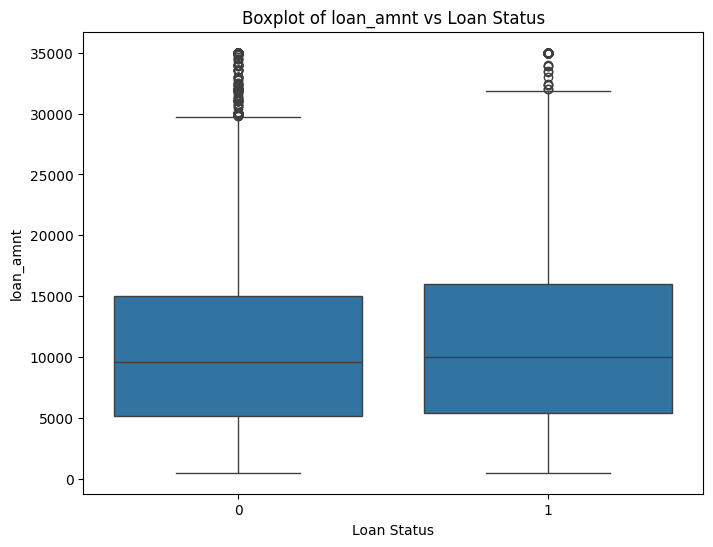

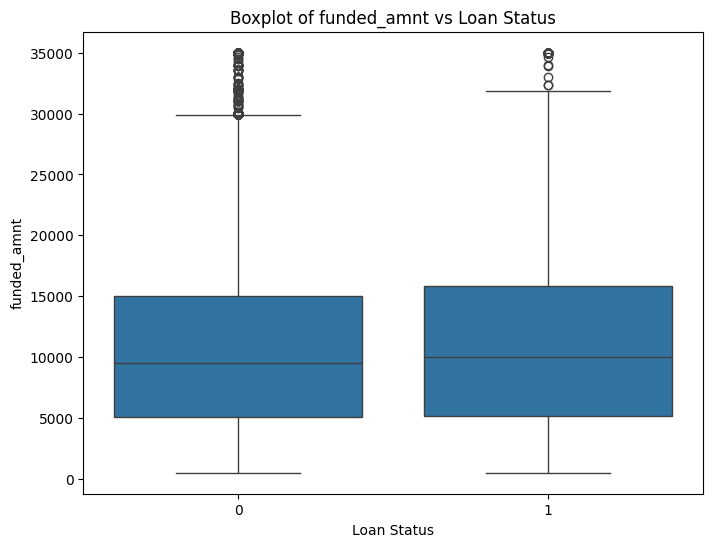

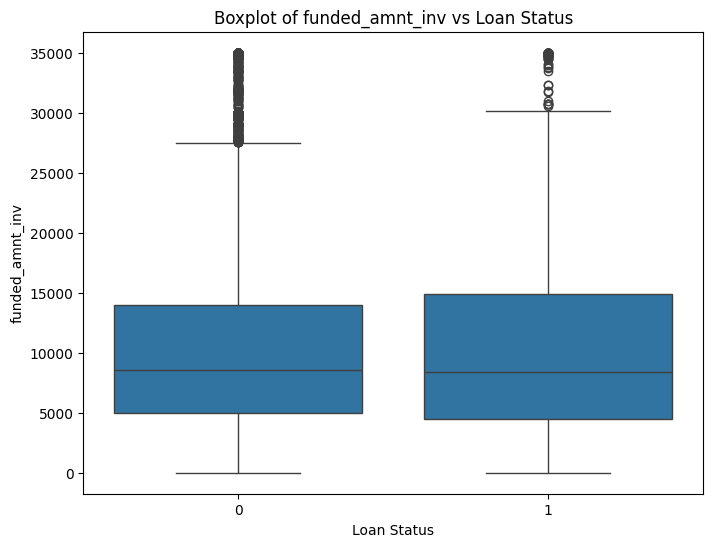

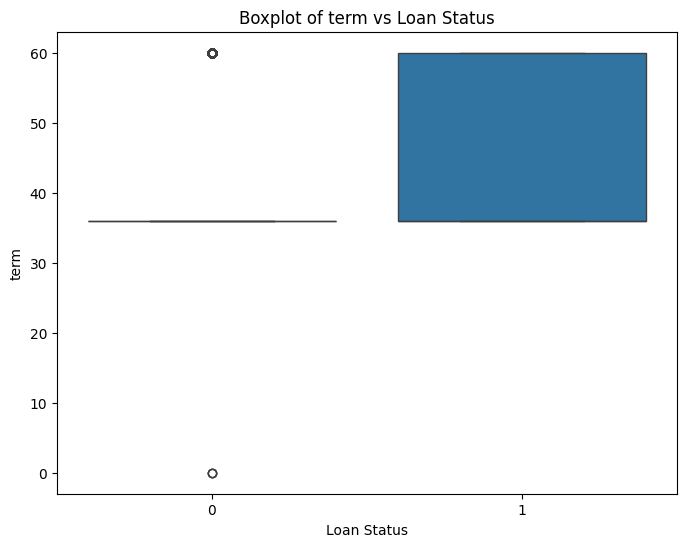

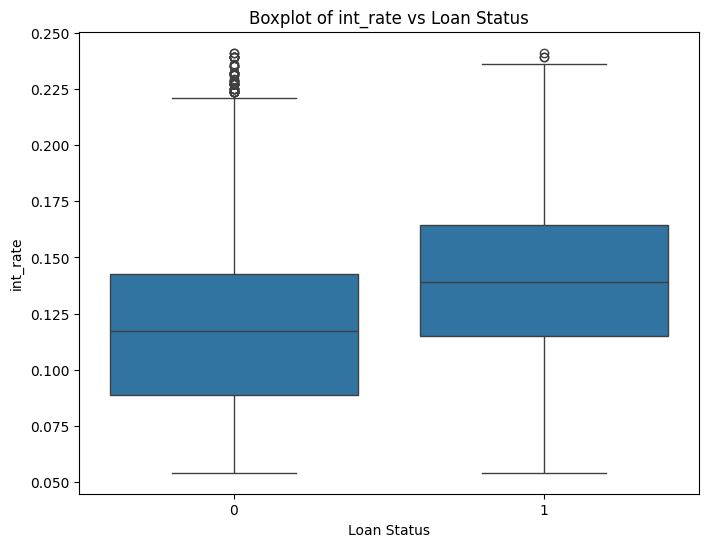

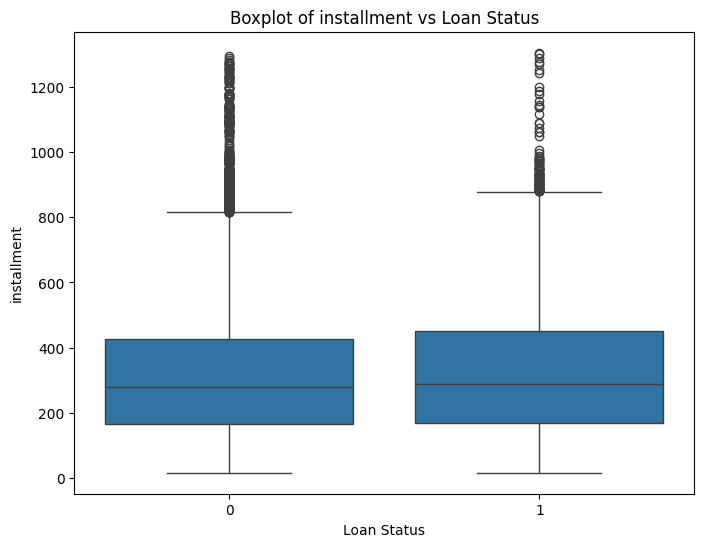

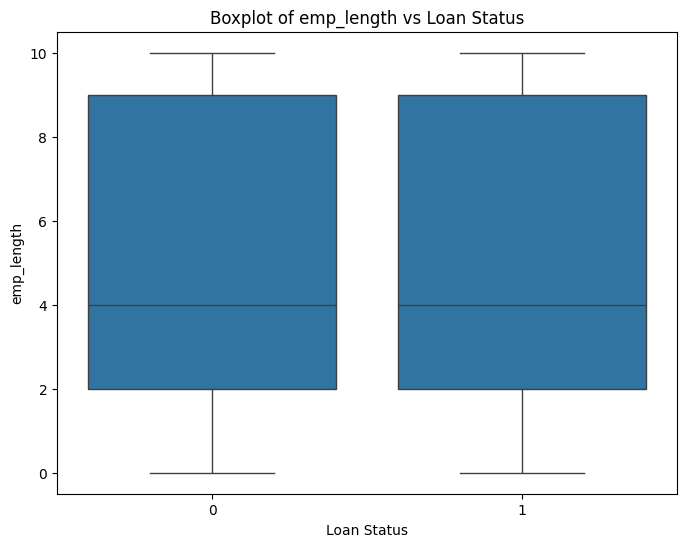

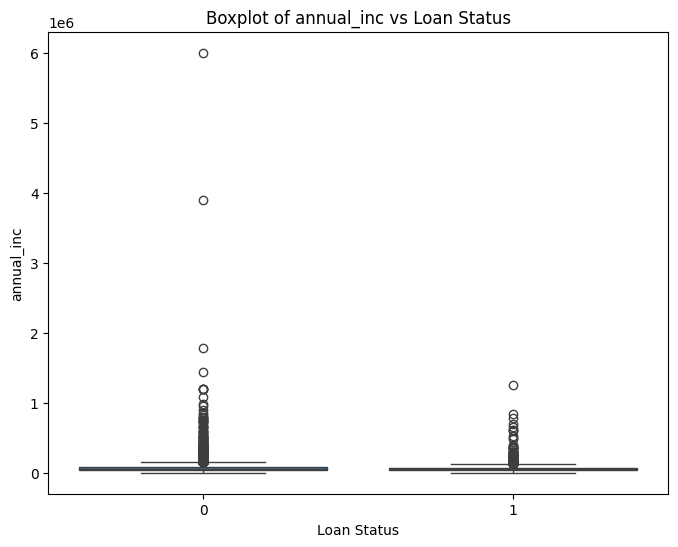

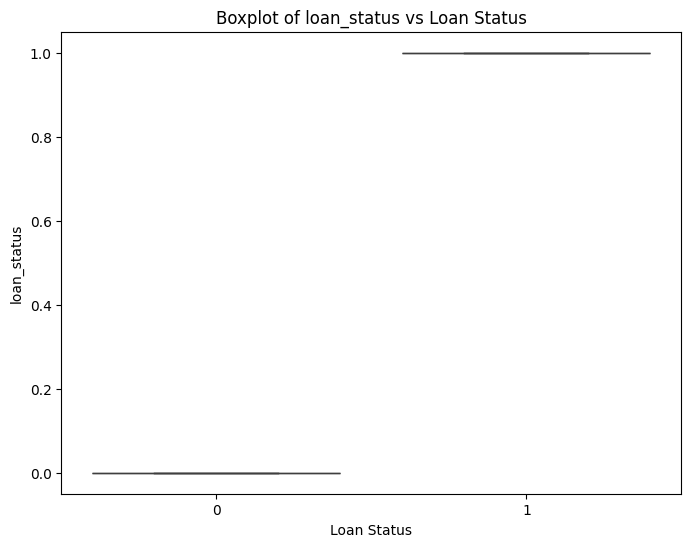

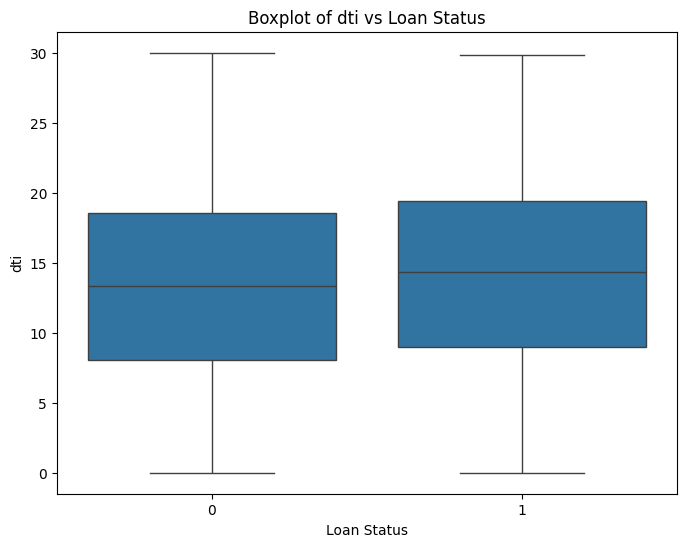

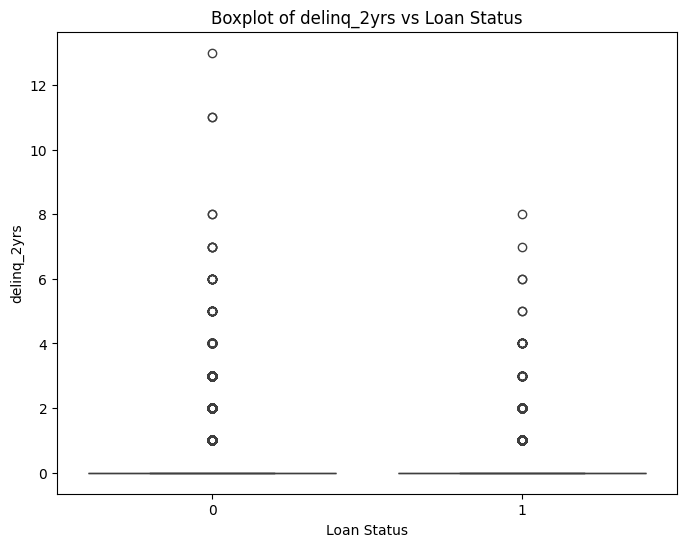

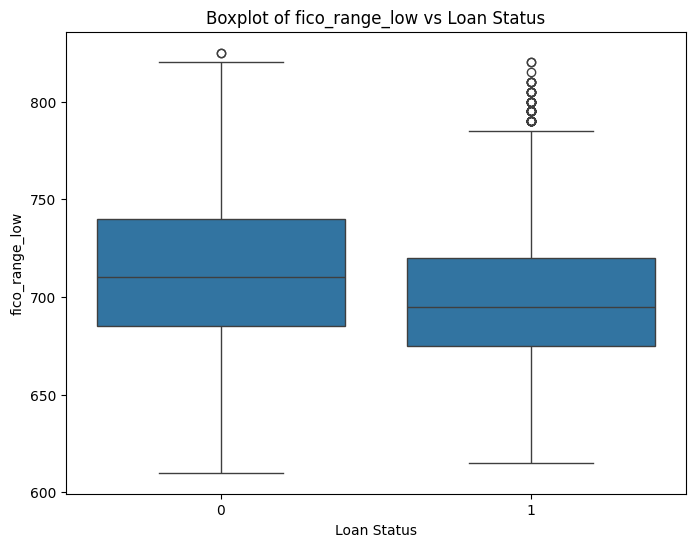

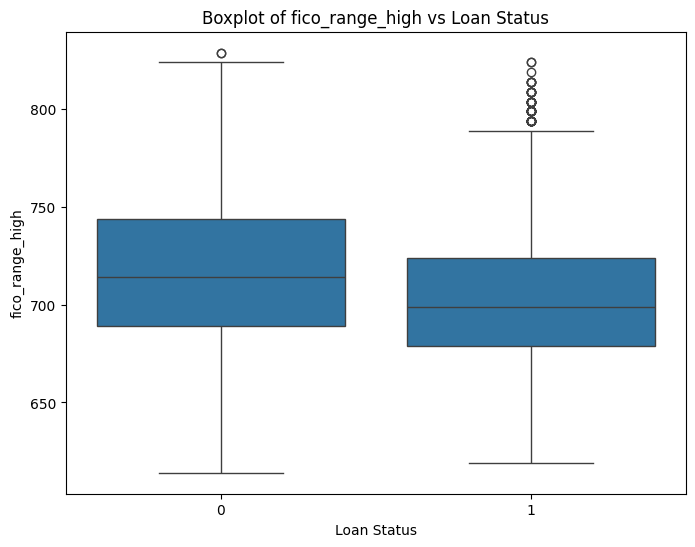

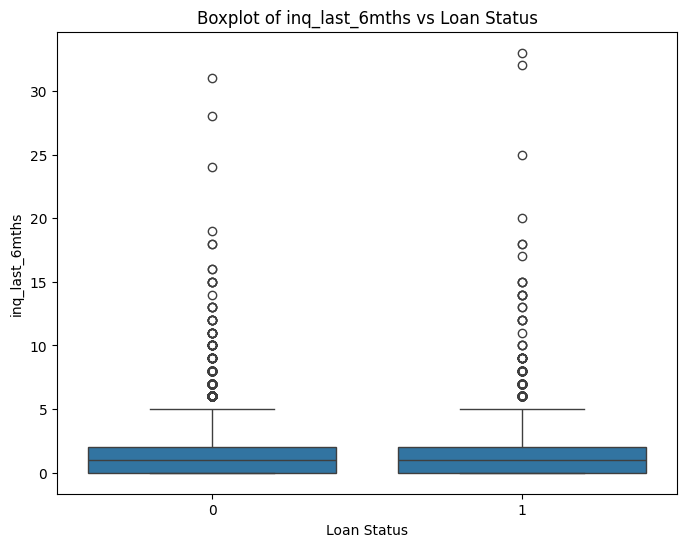

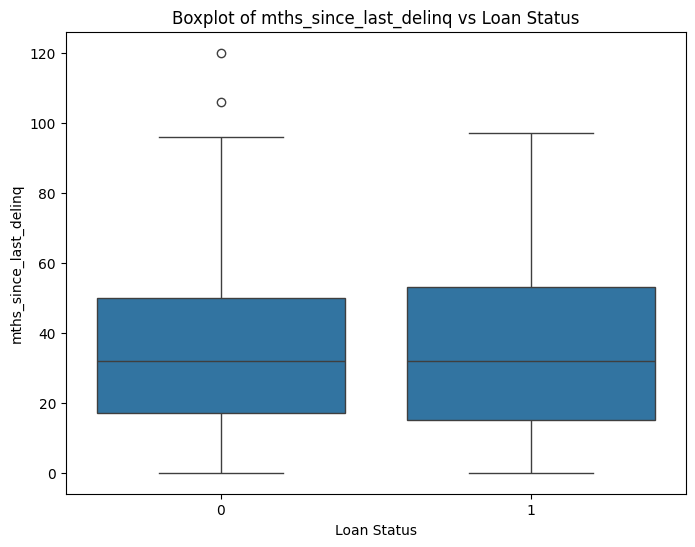

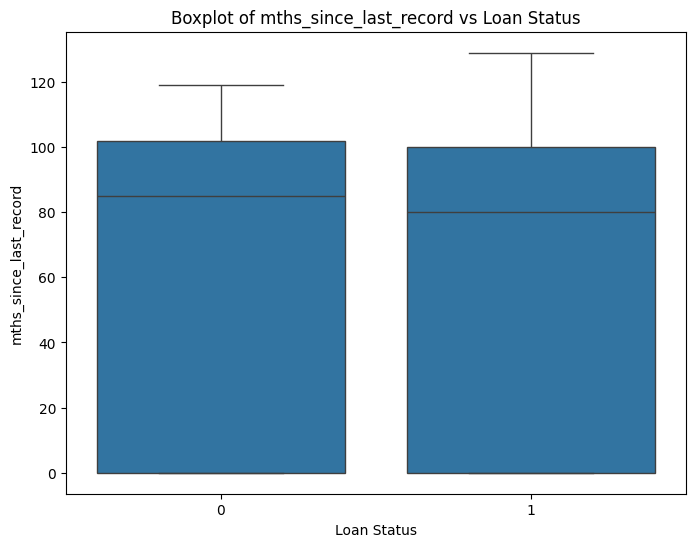

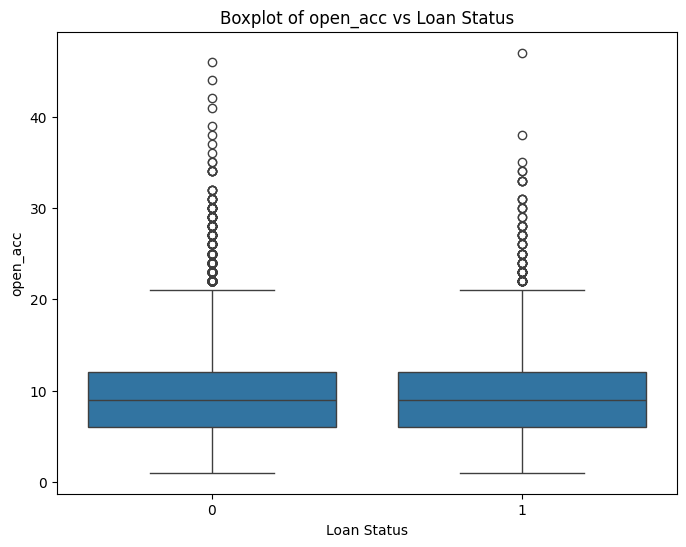

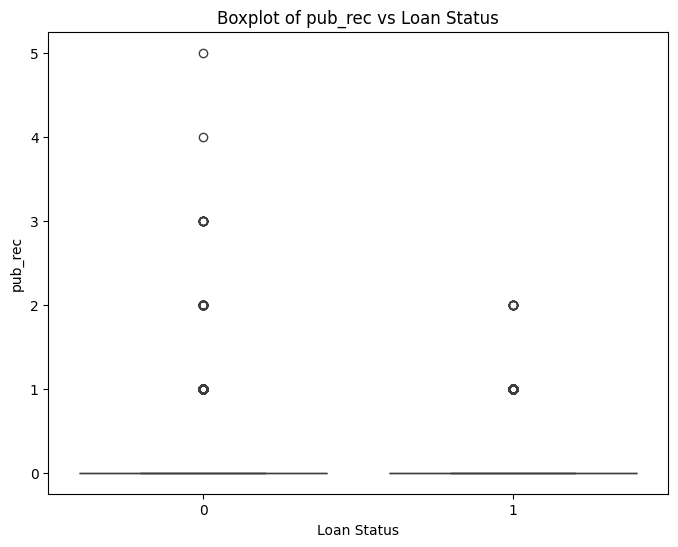

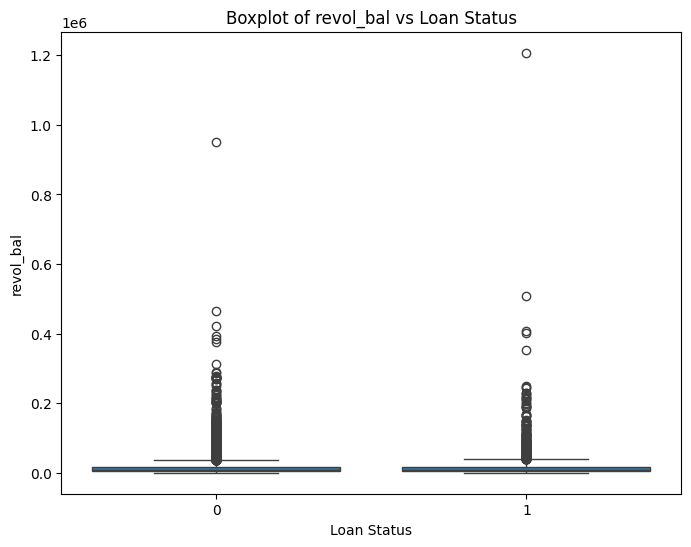

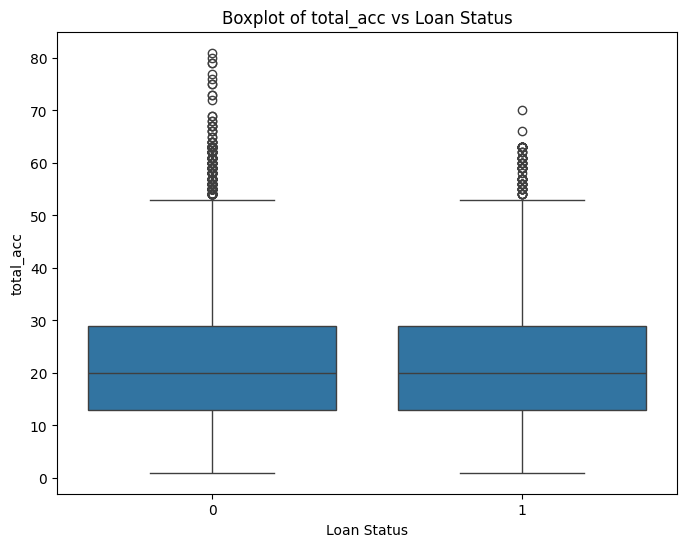

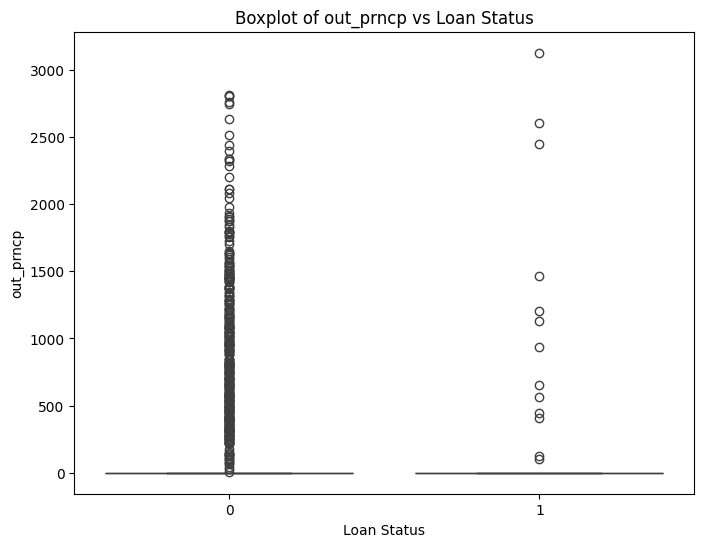

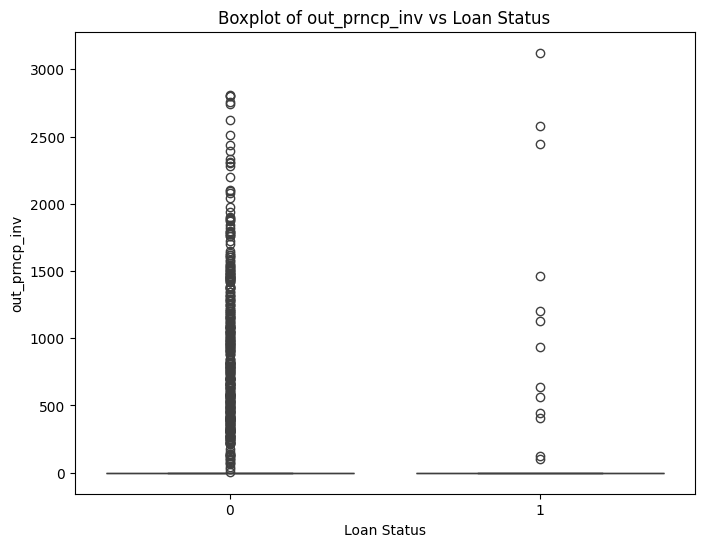

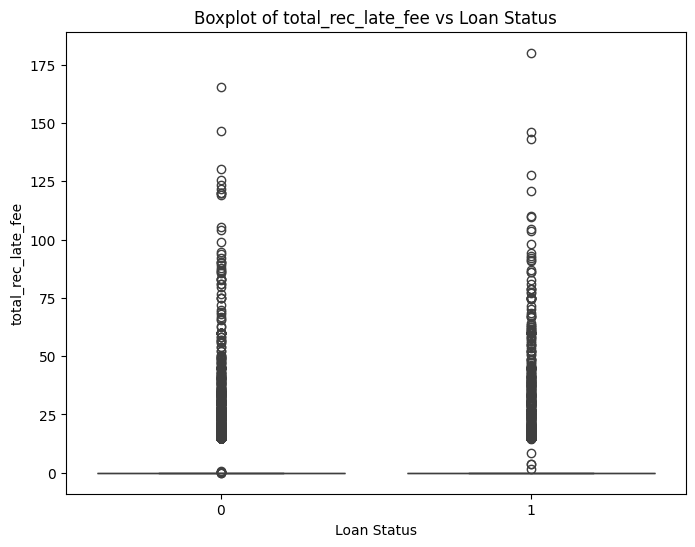

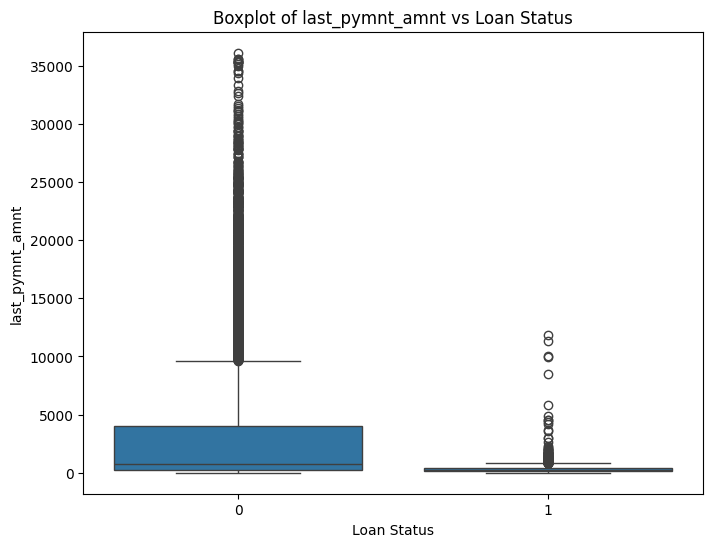

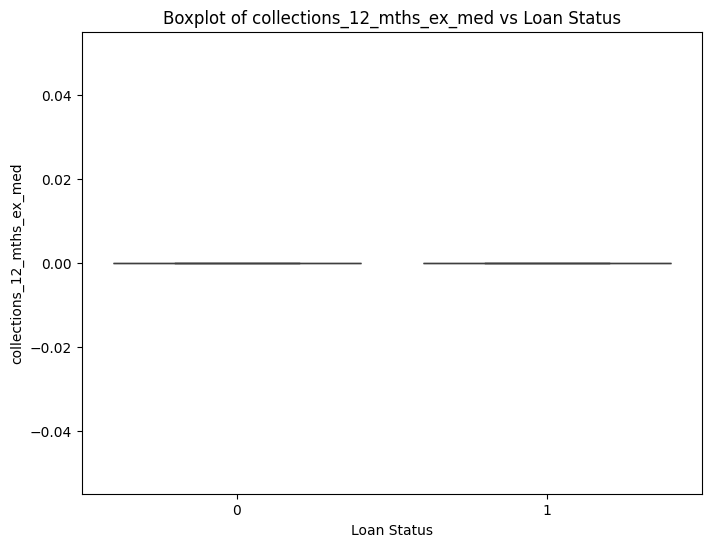

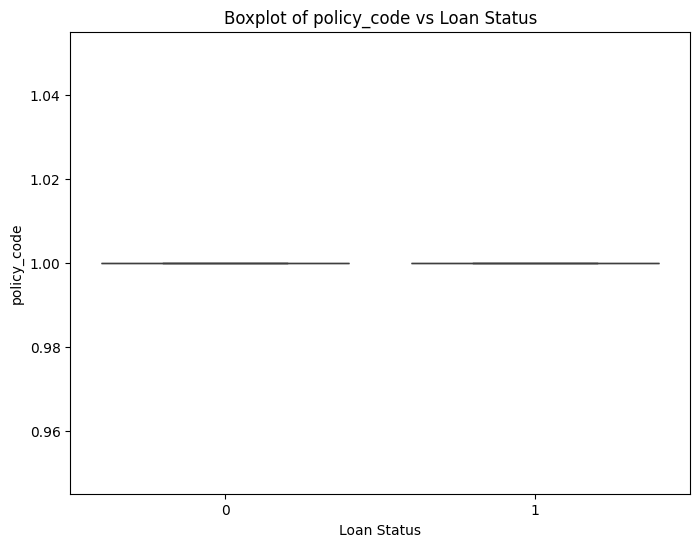

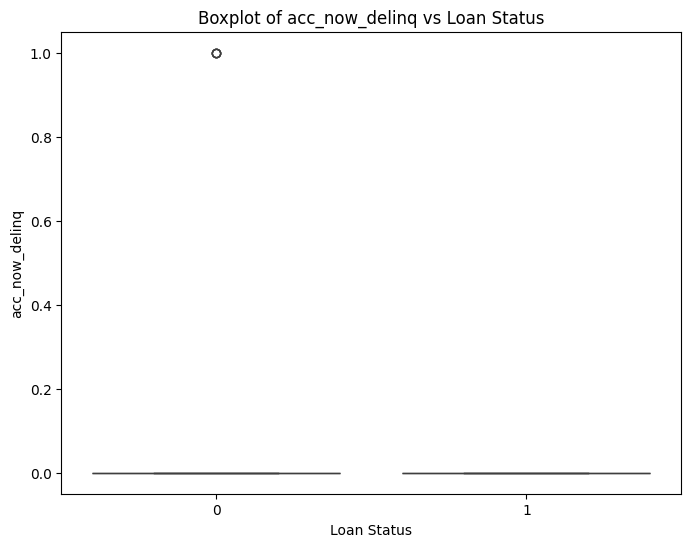

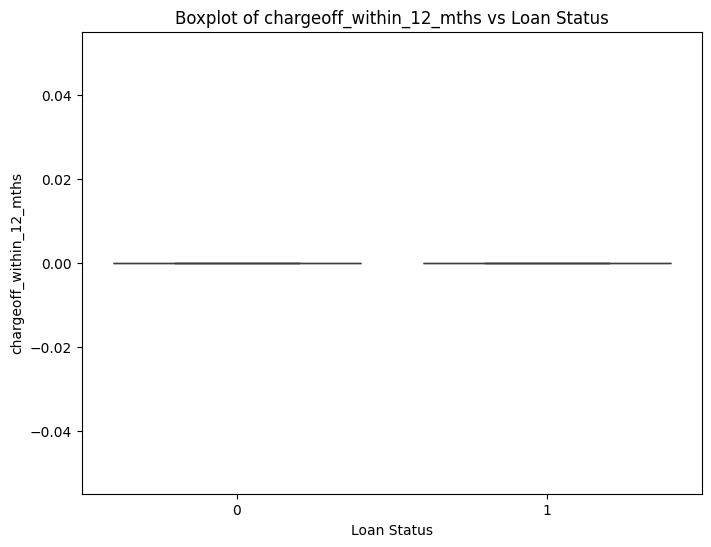

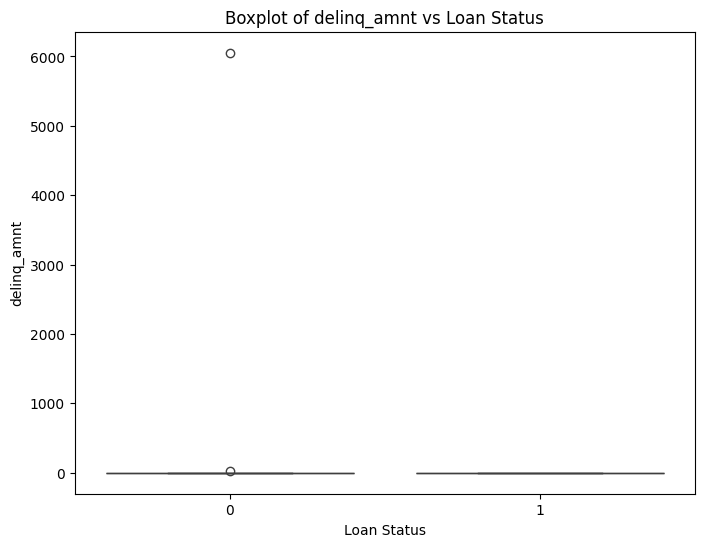

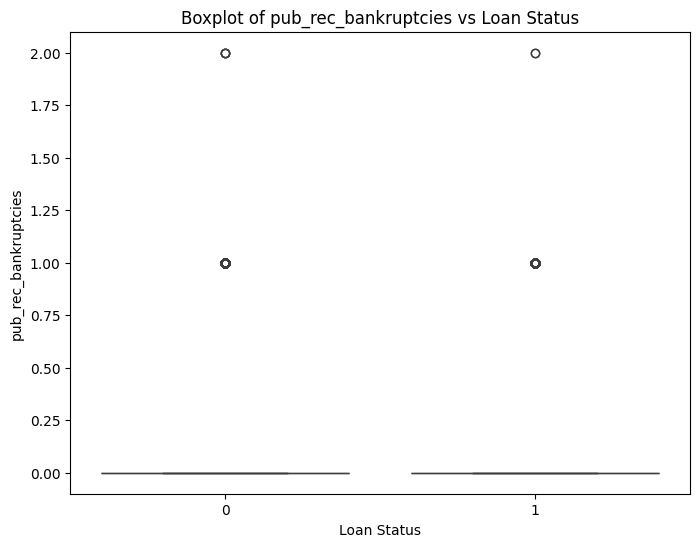

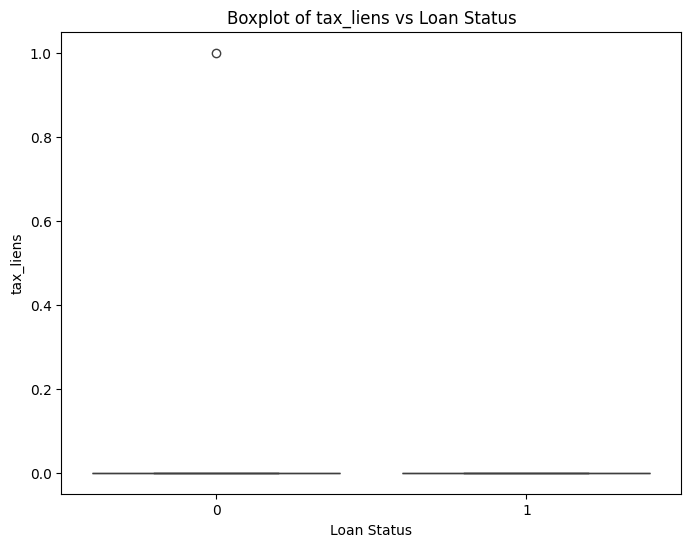

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric features
numeric_features = loan.select_dtypes(include=['int64', 'float64']).columns
numeric_features = [col for col in numeric_features if col not in ['id', 'member_id']]

# Create boxplots for each numeric feature versus the target variable
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='loan_status', y=feature, data=loan)
    plt.title(f'Boxplot of {feature} vs Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel(feature)
    plt.show()


## Categorical analysis vs Target

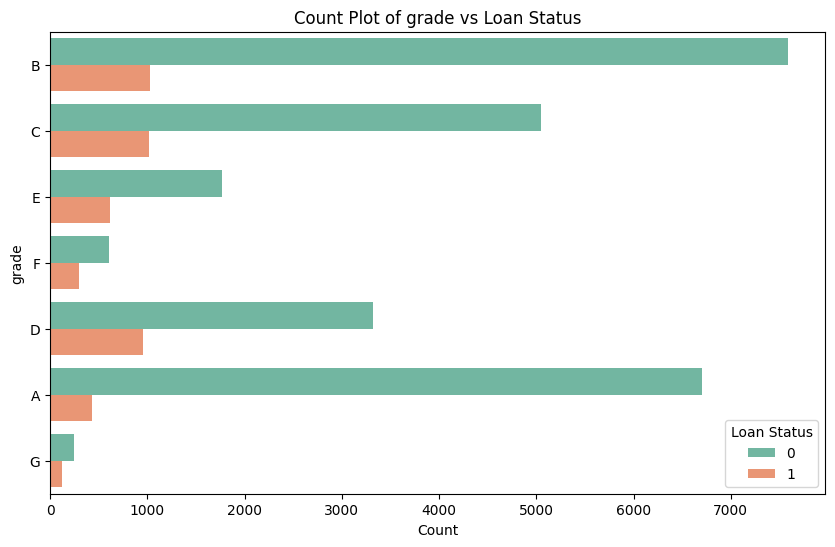

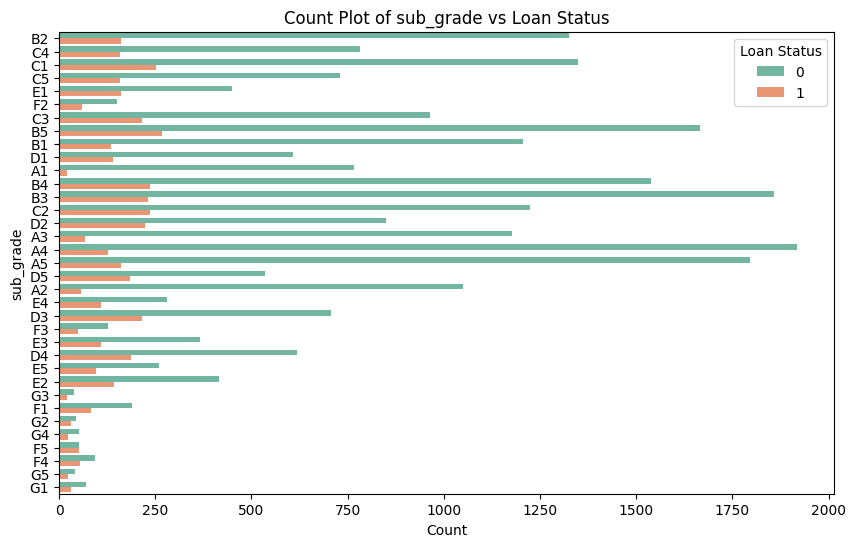

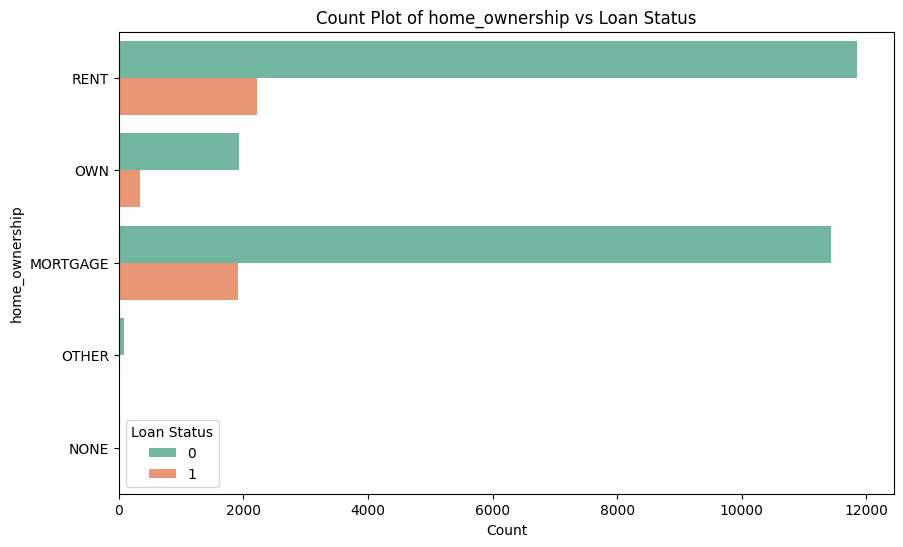

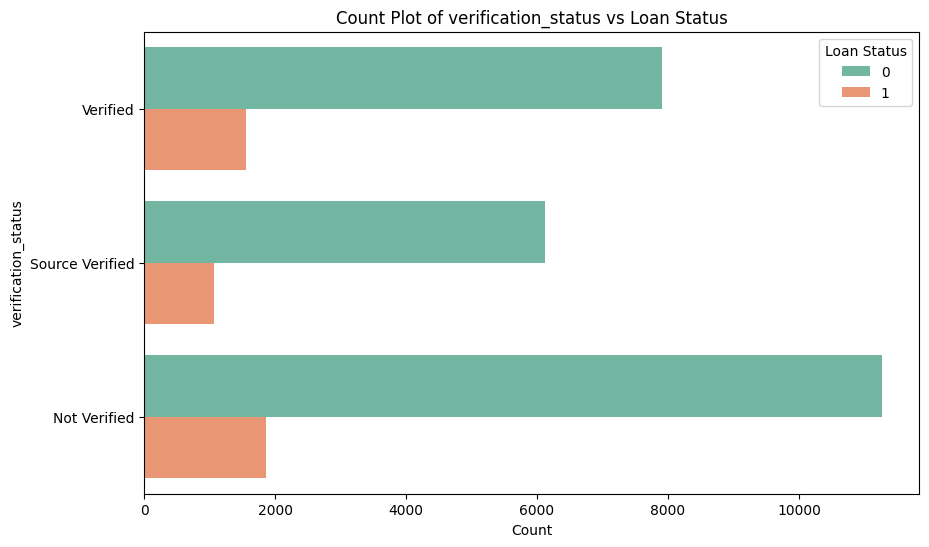

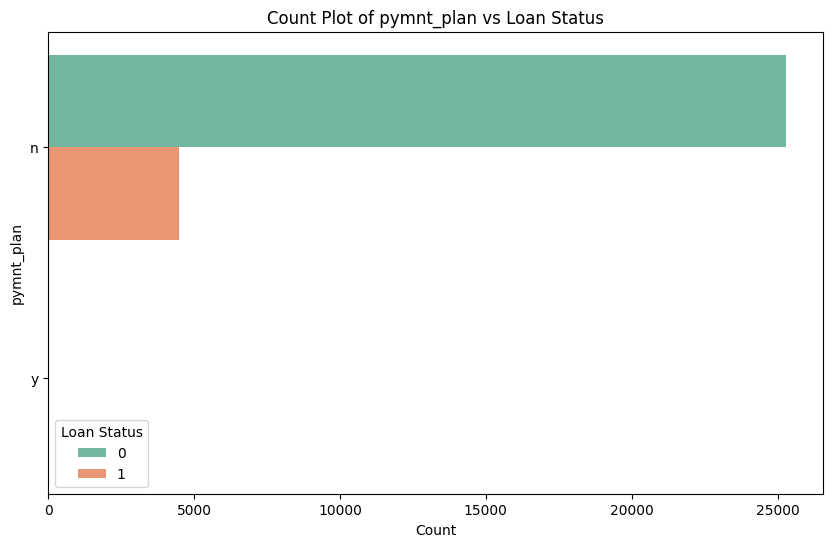

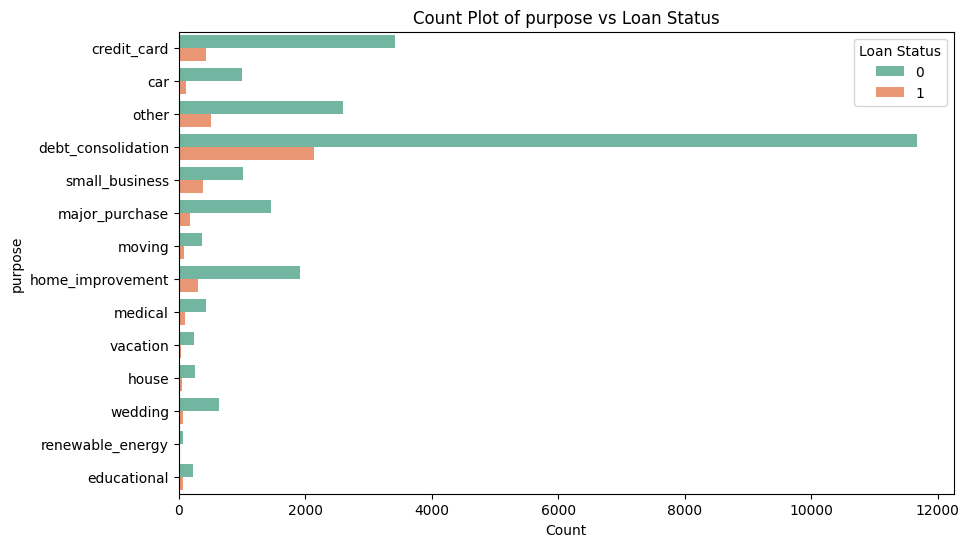

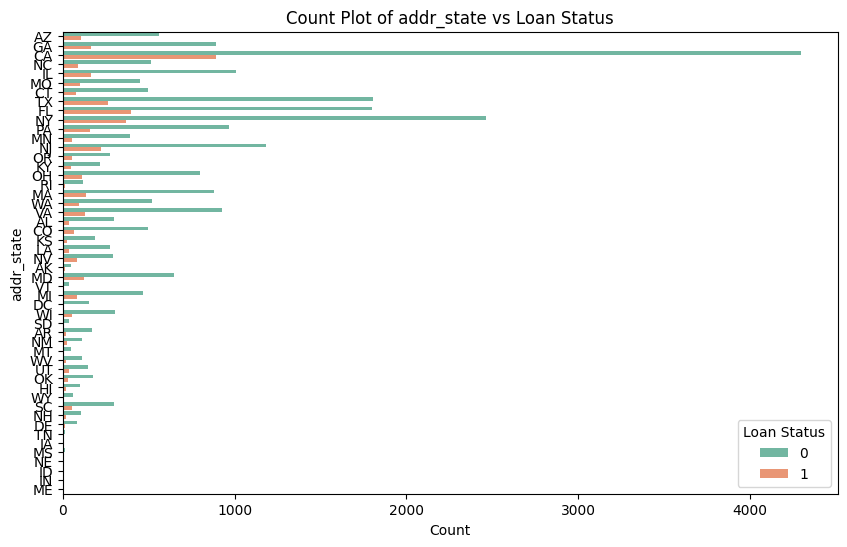

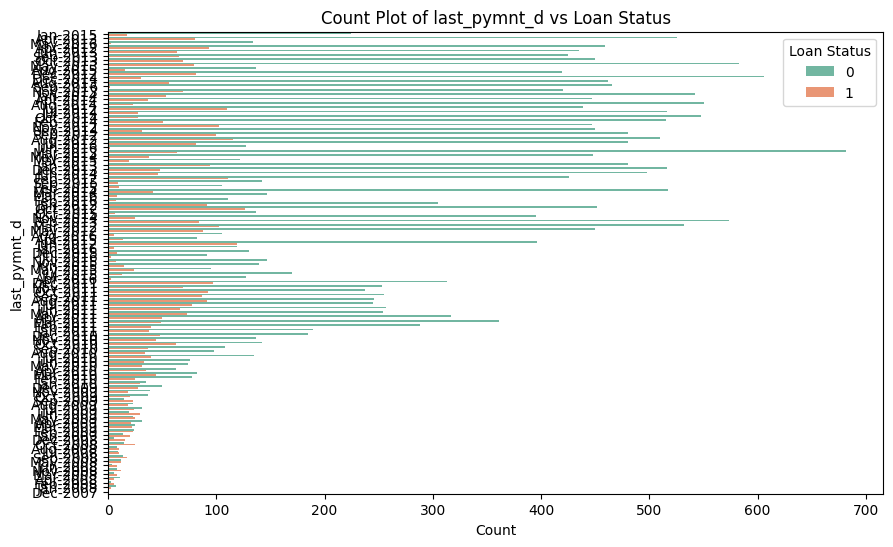

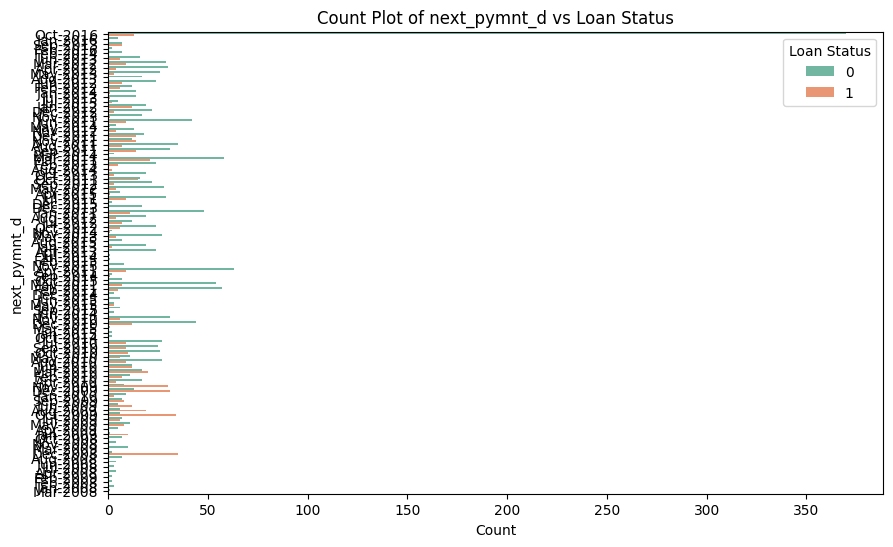

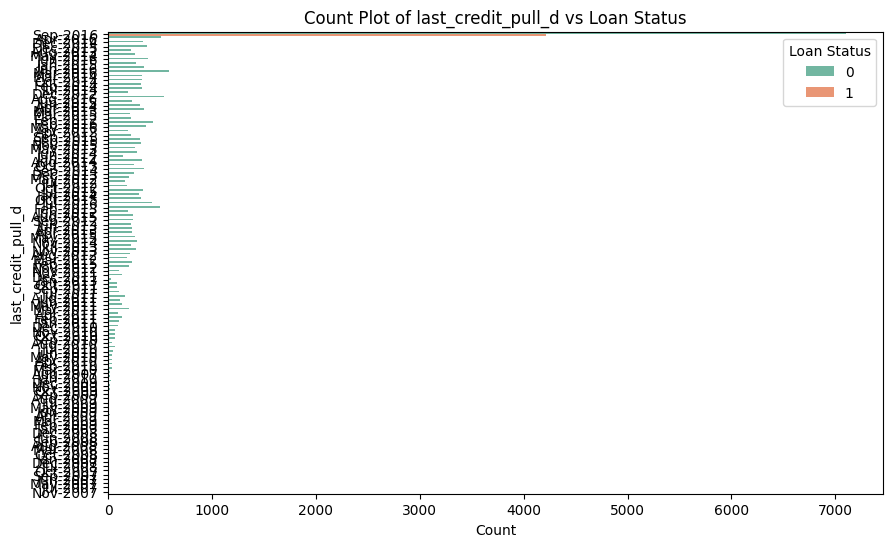

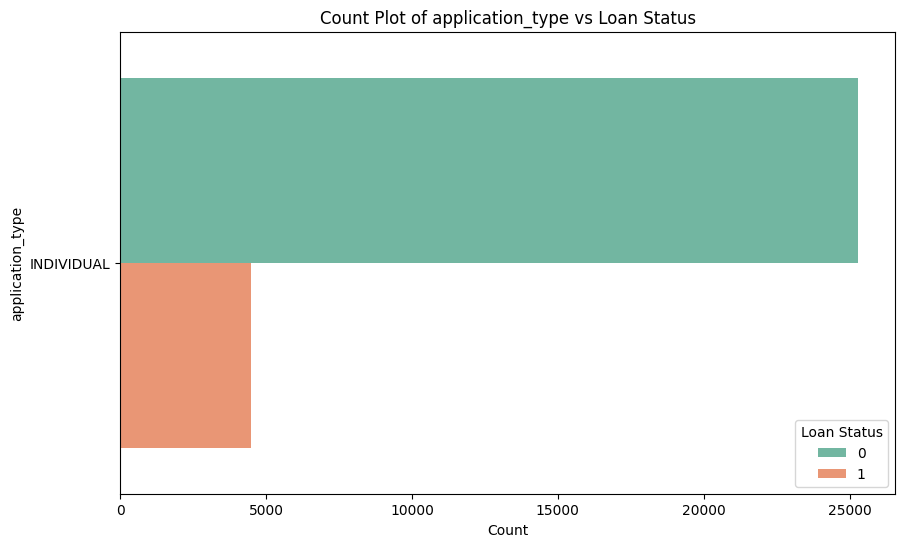

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select object-type features excluding specified columns
object_features = loan.select_dtypes(include=['object']).columns
exclude_columns = ['url', 'desc', 'title', 'emp_title', 'issue_d','zip_code','earliest_cr_line','revol_util']
object_features = [col for col in object_features if col not in exclude_columns]

# Create count plots for each remaining object-type feature versus the target variable
for feature in object_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=feature, hue='loan_status', data=loan, palette='Set2')
    plt.title(f'Count Plot of {feature} vs Loan Status')
    plt.xlabel('Count')
    plt.ylabel(feature)
    plt.legend(title='Loan Status')
    plt.show()



## Features

Here i just select some features to use.

In [80]:
numeric_features = loan.select_dtypes(include=['int64', 'float64']).columns
print(numeric_features)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'loan_status', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')


In [81]:
categorical_features = loan.select_dtypes(include=['object']).columns
print(categorical_features)

Index(['grade', 'sub_grade', 'emp_title', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'url', 'desc',
       'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line',
       'revol_util', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d',
       'application_type'],
      dtype='object')


In [82]:
numeric_features = ['term','int_rate','emp_length','loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee',
       'last_pymnt_amnt']
print(numeric_features)

categorical_features = ['grade', 'sub_grade','home_ownership', 'verification_status','purpose','addr_state']
print(categorical_features)

['term', 'int_rate', 'emp_length', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_amnt']
['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state']


# Model Development

## Model Training

### Train Test Split

In [83]:
X_train, X_test, y_train, y_test = train_test_split(loan[numeric_features + categorical_features], loan[target], test_size=0.2, random_state=42)


### Generate a pipeline

1. Setup Pipeline
2. Fit the Pipeline

In [22]:
# base estimators for stacker
base_estimators = [
    ('gbm', GradientBoostingClassifier(learning_rate=0.5, max_depth=6, n_estimators=24, random_state=42)),
    ('rf', RandomForestClassifier(max_depth=7, n_estimators=30)),
    ('nn', MLPClassifier(alpha=0.01,random_state=42))
]

In [23]:
# -- define pipeline --
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',  OneHotEncoder())
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
     ('scale', StandardScaler())])

preprocessing = ColumnTransformer(transformers=[
    ('cat', categorical_pipe, categorical_features),
    ('num', numerical_pipe, numeric_features)
    ])

log_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', LogisticRegression())
])

rf_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier',RandomForestClassifier(n_estimators=20, max_depth= None, min_samples_split=5, random_state=42))
])


gbm_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier',GradientBoostingClassifier(n_estimators=30, learning_rate=1, max_depth=3, random_state=42))
])

mlp_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', MLPClassifier(solver='adam', hidden_layer_sizes=(200,), alpha=0.001, activation='tanh', random_state=42))
])

stacking_classifier = StackingClassifier(
    estimators=base_estimators, final_estimator=LogisticRegression(),
    cv=3, n_jobs=-1
)

stk_pipeline = Pipeline(steps=[('preprocessor', preprocessing),
                           ('classifier', stacking_classifier)])



log_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)
gbm_pipeline.fit(X_train, y_train)
mlp_pipeline.fit(X_train, y_train)
stk_pipeline.fit(X_train, y_train)

print("training complete")

training complete


In [ ]:
stk_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['grade', 'sub_grade',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'purpose', 'addr_state']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  [...
                                                   'out_prncp', 'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'last_pymnt_amnt'])])),
                ('classifier',
                 StackingClassifier(cv=3,
                                    estimators=[('gbm',
                                                 GradientBoostingClassifier(learning_rate=1.0,
                                                                            n_estimators=30,
                                                                            random_state=42)),
                                                ('rf',
                                                 RandomForestClassifier(n_estimators=25,
                                                                        random_state=42)),
                                                ('nn',
                                                 MLPClassifier(random_state=42))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1))])

## Parameter Tuning

### Tuning for random forest

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
# Create the parameter grid
param_grid = {
    'classifier__n_estimators': [20, 30, 50],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [ 5, 10],
    #'classifier__min_samples_leaf': [1, 2, 4]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters:
  classifier__max_depth: None
  classifier__min_samples_split: 5
  classifier__n_estimators: 20


### Tuning for GBM

In [25]:
# Create the parameter grid
param_grid = {
    'classifier__n_estimators': [30,50,100],
    'classifier__learning_rate': [1,2,3],
    'classifier__max_depth': [3,5,7]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(gbm_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters:
  classifier__learning_rate: 1
  classifier__max_depth: 3
  classifier__n_estimators: 30


### Tuning for MLP

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

# Define the parameter grid for MLPClassifier
param_dist = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (200,)],
    'classifier__activation': ['relu', 'tanh', 'logistic'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.01]
}

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(mlp_pipeline, param_dist, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = random_search.best_params_

# Print the best set of hyperparameters
print("Best parameters for MLPClassifier:")
for key, value in best_params.items():
    print(f"  {key}: {value}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for MLPClassifier:
  classifier__solver: adam
  classifier__hidden_layer_sizes: (200,)
  classifier__alpha: 0.001
  classifier__activation: tanh


### Tuning for Stacking

In [26]:
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define a parameter grid and specify the parameters to be tuned.
# use the name of the step in the pipeline followed by two underscores '__' and then the parameter name.
param_distributions = {
    'classifier__gbm__n_estimators': randint(10, 100),
    'classifier__gbm__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'classifier__gbm__max_depth': randint(3, 10),
    'classifier__rf__n_estimators': randint(10, 100),
    'classifier__rf__max_depth': randint(3, 10),
    'classifier__nn__alpha': [0.0001, 0.001, 0.01, 0.1],
}

# Create the RandomizedSearchCV object.adjust n_iter and cv (number of iterations and cross-validation folds).
random_search = RandomizedSearchCV(stk_pipeline, param_distributions=param_distributions, n_iter=2, cv=3, verbose=2, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# After fitting, get the best parameters and use them with classifier
print("Best parameters found: ", random_search.best_params_)

# Use the best estimator directly to make predictions
# X_test is test data
predictions = random_search.predict(X_test)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters found:  {'classifier__gbm__learning_rate': 0.5, 'classifier__gbm__max_depth': 6, 'classifier__gbm__n_estimators': 24, 'classifier__nn__alpha': 0.01, 'classifier__rf__max_depth': 7, 'classifier__rf__n_estimators': 30}


# Global Model Explanations

## 1. Model Comparison

### Accuracy, Precision,Recall,, F1 Score, AUC

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def calculate_metrics(pipeline, X, y):
    # Predictions
    y_pred = pipeline.predict(X)
    y_prob = pipeline.predict_proba(X)[:, 1]

    # Binarize labels for AUC calculation
    lb = LabelBinarizer()
    y_binarized = lb.fit_transform(y).ravel()

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y_binarized, y_prob)

    return accuracy, precision, recall, f1, auc

# Define a list of pipelines
pipelines = [log_pipeline, rf_pipeline, gbm_pipeline, mlp_pipeline, stk_pipeline]

# Define a list of pipeline names
pipeline_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'MLP', 'Stacking Classifier']

# Loop through pipelines and print metrics
for pipeline, name in zip(pipelines, pipeline_names):
    print(f"\nMetrics for {name}:")
    train_metrics = calculate_metrics(pipeline, X_train, y_train)
    test_metrics = calculate_metrics(pipeline, X_test, y_test)

    print("Training Metrics:")
    print(f"Accuracy: {train_metrics[0]:.2f}")
    print(f"Precision: {train_metrics[1]:.2f}")
    print(f"Recall: {train_metrics[2]:.2f}")
    print(f"F1 Score: {train_metrics[3]:.2f}")
    print(f"AUC: {train_metrics[4]:.2f}")

    print("\nTest Metrics:")
    print(f"Accuracy: {test_metrics[0]:.2f}")
    print(f"Precision: {test_metrics[1]:.2f}")
    print(f"Recall: {test_metrics[2]:.2f}")
    print(f"F1 Score: {test_metrics[3]:.2f}")
    print(f"AUC: {test_metrics[4]:.2f}")



Metrics for Logistic Regression:
Training Metrics:
Accuracy: 0.87
Precision: 0.66
Recall: 0.30
F1 Score: 0.41
AUC: 0.88

Test Metrics:
Accuracy: 0.87
Precision: 0.62
Recall: 0.28
F1 Score: 0.39
AUC: 0.86

Metrics for Random Forest:
Training Metrics:
Accuracy: 0.98
Precision: 1.00
Recall: 0.87
F1 Score: 0.93
AUC: 1.00

Test Metrics:
Accuracy: 0.86
Precision: 0.61
Recall: 0.18
F1 Score: 0.27
AUC: 0.84

Metrics for Gradient Boosting:
Training Metrics:
Accuracy: 0.90
Precision: 0.74
Recall: 0.49
F1 Score: 0.59
AUC: 0.93

Test Metrics:
Accuracy: 0.88
Precision: 0.63
Recall: 0.40
F1 Score: 0.49
AUC: 0.89

Metrics for MLP:
Training Metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
AUC: 1.00

Test Metrics:
Accuracy: 0.84
Precision: 0.43
Recall: 0.37
F1 Score: 0.40
AUC: 0.81

Metrics for Stacking Classifier:
Training Metrics:
Accuracy: 0.93
Precision: 0.89
Recall: 0.60
F1 Score: 0.72
AUC: 0.96

Test Metrics:
Accuracy: 0.88
Precision: 0.68
Recall: 0.40
F1 Score: 0.51
AUC: 0.90

## ROC chart& PR Curve on Test set
- logistic Regression
- RandomForest
- GradientBoosting
- MLPClassifier
- StackingClassifier
- Report, accuracy, auc, feature importance, ROC chart and FPR table

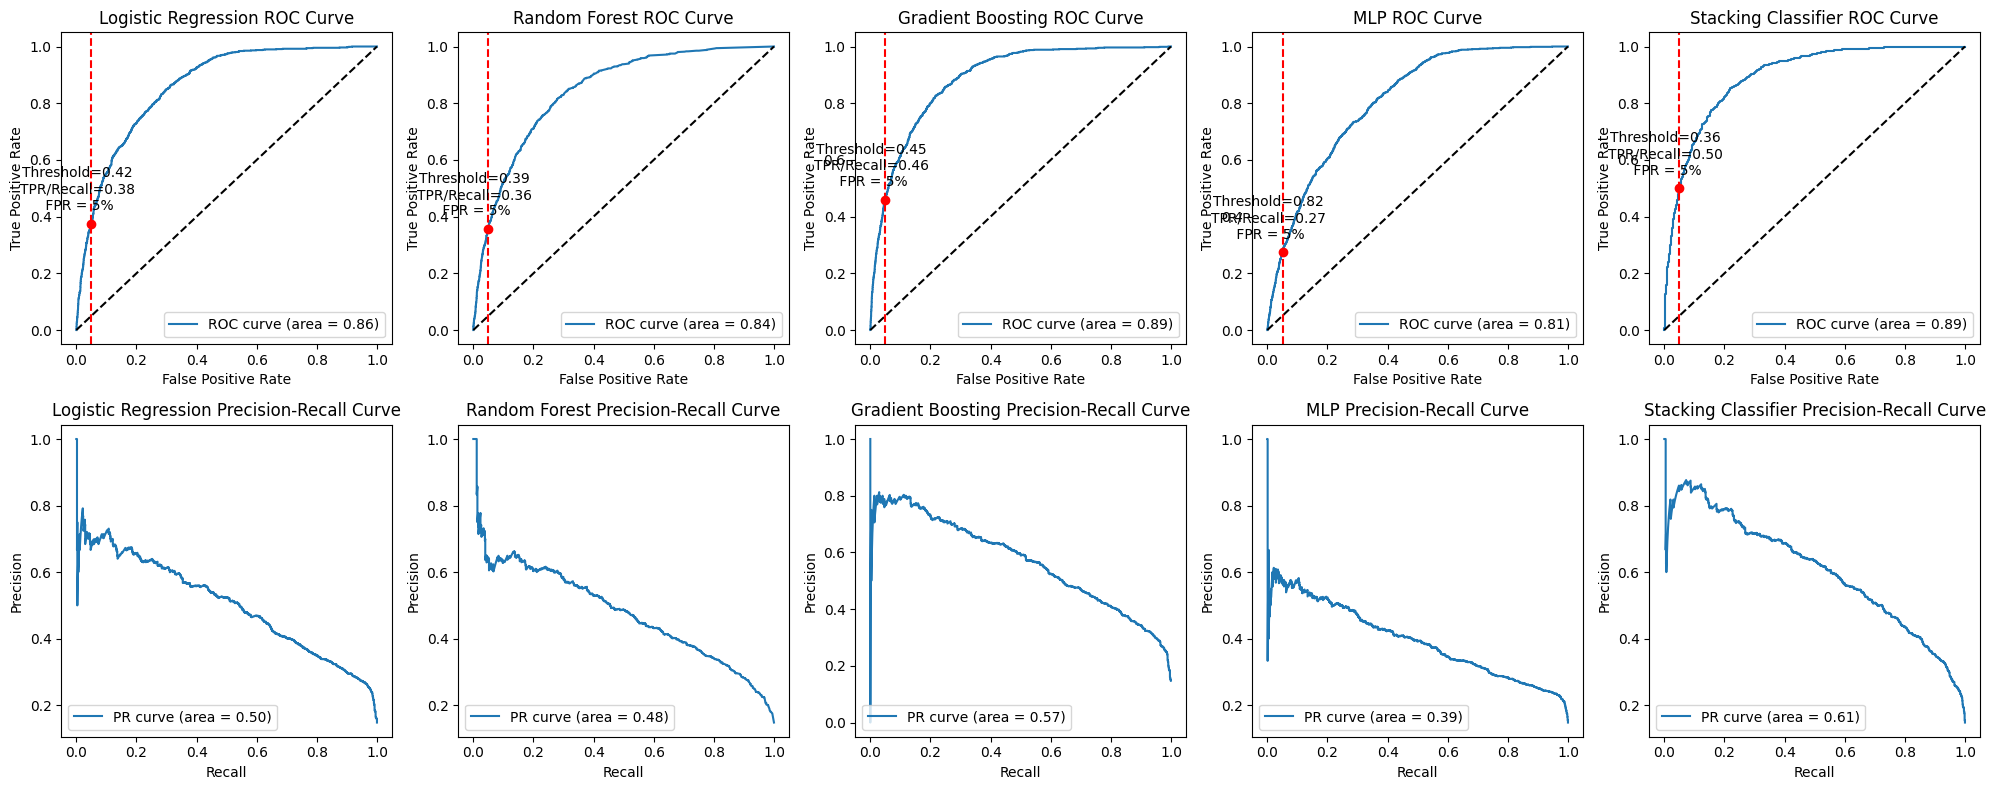

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Define the pipelines
pipelines = [log_pipeline, rf_pipeline, gbm_pipeline, mlp_pipeline, stk_pipeline]
pipeline_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'MLP', 'Stacking Classifier']

# Create a figure for the subplots
plt.figure(figsize=(20, 8))

# Loop through each pipeline
for i, (pipeline, name) in enumerate(zip(pipelines, pipeline_names)):
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict probabilities for the test set
    y_test_prob = pipeline.predict_proba(X_test)[:, 1]

    # Binarize labels for AUC calculation
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test).ravel()

    # Calculate ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.subplot(2, 5, i+1)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal

    # Find the index of the FPR just over 2%
    idx_02 = next(i for i, x in enumerate(fpr) if x >= 0.02)
    plt.plot(fpr[idx_02], tpr[idx_02], 'ro')
    plt.annotate(f'Threshold={thresholds_roc[idx_02]:.2f}\nTPR/Recall={tpr[idx_02]:.2f}\n FPR = 2%', (fpr[idx_02], tpr[idx_02]), textcoords="offset points", xytext=(-10,10), ha='center')



    # Highlight the 5% FPR point with a vertical line and text annotation
    idx = next(i for i, x in enumerate(fpr) if x >= 0.05)  # Find the index for FPR just over 5%
    plt.axvline(x=fpr[idx], color='r', linestyle='--')  # Vertical line for ~5% FPR
    plt.plot(fpr[idx], tpr[idx], 'ro')  # Red dot at the intersection
    plt.annotate(f'Threshold={thresholds_roc[idx]:.2f}\nTPR/Recall={tpr[idx]:.2f}\n FPR = 5%', (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,10), ha='center')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc="lower right")

    # Plot Precision-Recall Curve
    plt.subplot(2, 5, i+6)
    precision, recall, _ = precision_recall_curve(y_test_binarized, y_test_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} Precision-Recall Curve')
    plt.legend(loc="lower left")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


## Operation Strategy at 5% FPR

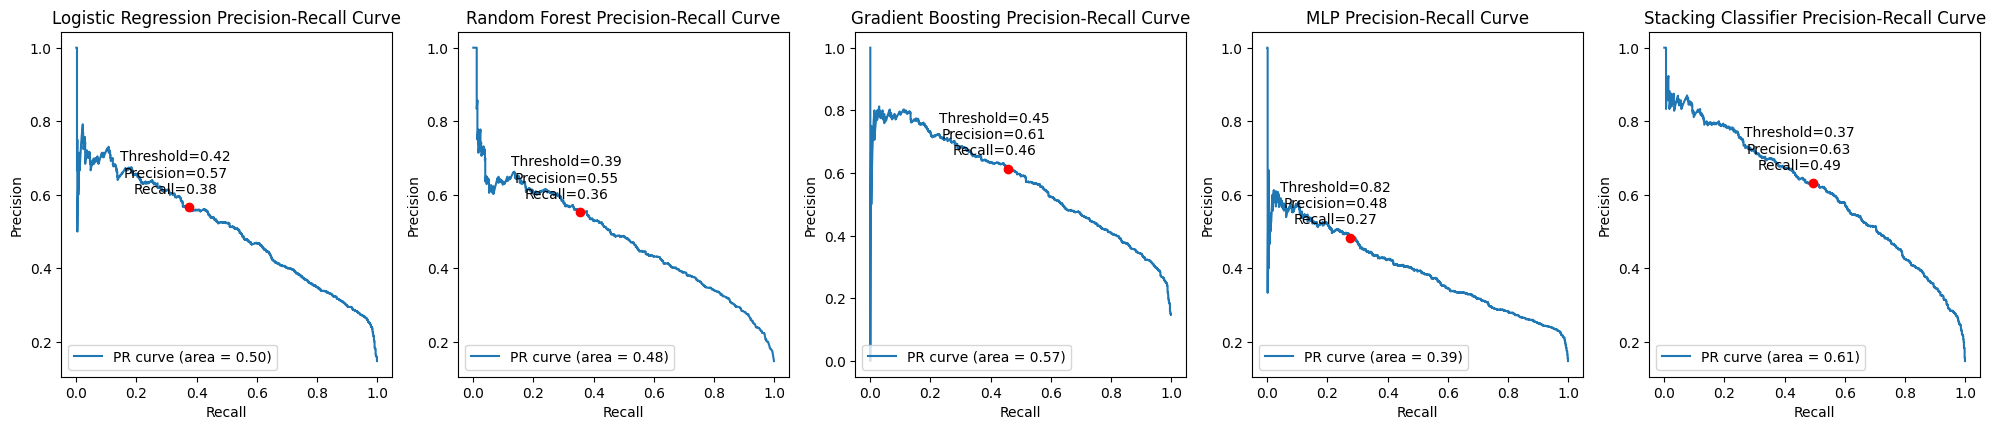

In [ ]:
import numpy as np

# Create a figure for the subplots
plt.figure(figsize=(20, 8))

# Loop through each pipeline
for i, (pipeline, name) in enumerate(zip(pipelines, pipeline_names)):
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict probabilities for the test set
    y_test_prob = pipeline.predict_proba(X_test)[:, 1]

    # Binarize labels for AUC calculation
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test).ravel()

    # Calculate ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
    roc_auc = auc(fpr, tpr)

    # Calculate Precision-Recall curve
    precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_test_prob)
    pr_auc = auc(recall, precision)

    # Plot PR Curve
    plt.subplot(2, 5, i+6)
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} Precision-Recall Curve')
    plt.legend(loc="lower left")

    # Find the index for FPR just over 5%
    idx = next(i for i, x in enumerate(fpr) if x >= 0.05)

    # Find the closest threshold in the PR curve to the one identified in the ROC curve analysis
    roc_threshold = thresholds_roc[idx]
    closest_threshold_index = np.argmin(np.abs(thresholds_pr - roc_threshold))
    selected_precision = precision[closest_threshold_index]
    selected_recall = recall[closest_threshold_index]

    # Highlight the selected threshold
    plt.plot(selected_recall, selected_precision, 'ro')  # Red dot at the selected threshold
    plt.annotate(f'Threshold={roc_threshold:.2f}\nPrecision={selected_precision:.2f}\nRecall={selected_recall:.2f}',
                 (selected_recall, selected_precision),
                 textcoords="offset points",
                 xytext=(-10,10),
                 ha='center')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


## Operation Strategy at 2% FPR

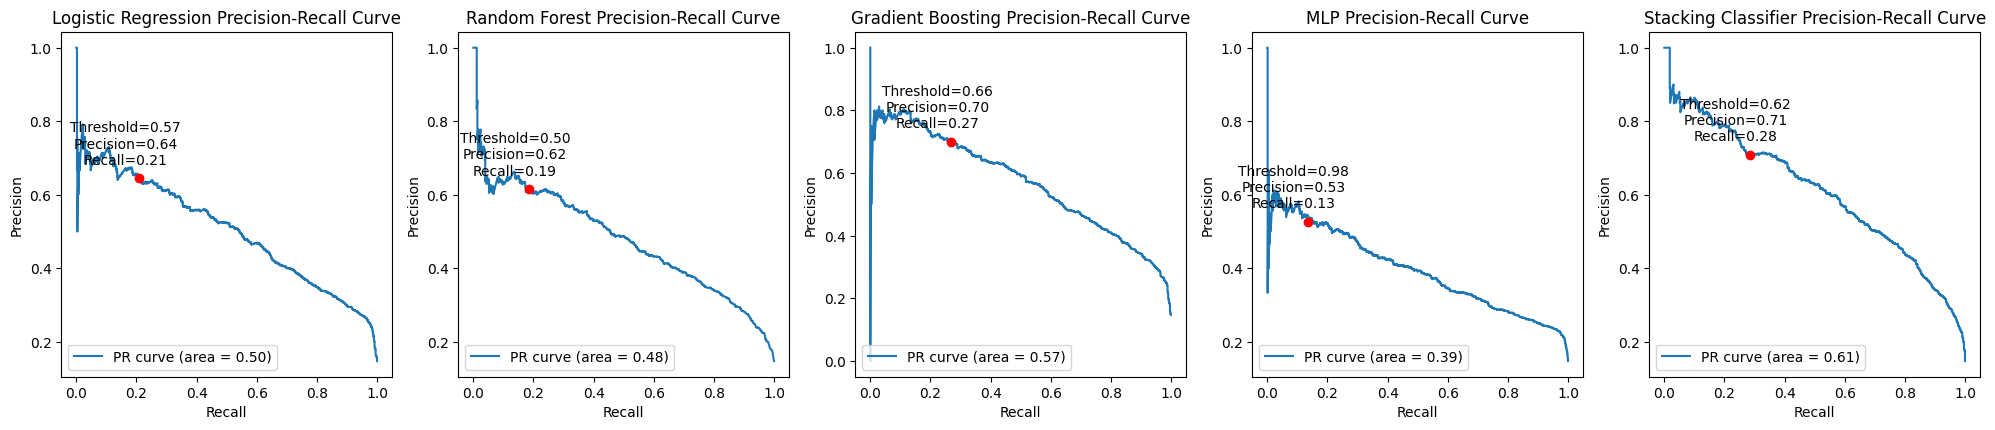

In [115]:
import numpy as np

# Create a figure for the subplots
plt.figure(figsize=(20, 8))

# Loop through each pipeline
for i, (pipeline, name) in enumerate(zip(pipelines, pipeline_names)):
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict probabilities for the test set
    y_test_prob = pipeline.predict_proba(X_test)[:, 1]

    # Binarize labels for AUC calculation
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test).ravel()

    # Calculate ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_test_binarized, y_test_prob)
    roc_auc = auc(fpr, tpr)

    # Calculate Precision-Recall curve
    precision, recall, thresholds_pr = precision_recall_curve(y_test_binarized, y_test_prob)
    pr_auc = auc(recall, precision)

    # Plot PR Curve
    plt.subplot(2, 5, i+6)
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} Precision-Recall Curve')
    plt.legend(loc="lower left")

    # Find the index for FPR just over 5%
    idx = next(i for i, x in enumerate(fpr) if x >= 0.02)

    # Find the closest threshold in the PR curve to the one identified in the ROC curve analysis
    roc_threshold = thresholds_roc[idx]
    closest_threshold_index = np.argmin(np.abs(thresholds_pr - roc_threshold))
    selected_precision = precision[closest_threshold_index]
    selected_recall = recall[closest_threshold_index]

    # Highlight the selected threshold
    plt.plot(selected_recall, selected_precision, 'ro')  # Red dot at the selected threshold
    plt.annotate(f'Threshold={roc_threshold:.2f}\nPrecision={selected_precision:.2f}\nRecall={selected_recall:.2f}',
                 (selected_recall, selected_precision),
                 textcoords="offset points",
                 xytext=(-10,10),
                 ha='center')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

## Feature Importance

### Permutation Importance


In [ ]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    feature_names = []

    # Loop through each transformer within the ColumnTransformer
    for name, transformer, columns in column_transformer.transformers_:
        if name == 'remainder':  # Skip the 'remainder' transformer, if present
            continue
        if isinstance(transformer, Pipeline):
            # If the transformer is a pipeline, get the last transformer from the pipeline
            transformer = transformer.steps[-1][1]

        if hasattr(transformer, 'get_feature_names_out'):
            # If the transformer has 'get_feature_names_out', use it
            names = list(transformer.get_feature_names_out(columns))
        else:
            # Otherwise, just use the column names directly
            names = list(columns)

        feature_names.extend(names)

    return feature_names

transformed_feature_names = get_feature_names(preprocessing)
transformed_feature_names

['grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'grade_missing',
 'sub_grade_A1',
 'sub_grade_A2',
 'sub_grade_A3',
 'sub_grade_A4',
 'sub_grade_A5',
 'sub_grade_B1',
 'sub_grade_B2',
 'sub_grade_B3',
 'sub_grade_B4',
 'sub_grade_B5',
 'sub_grade_C1',
 'sub_grade_C2',
 'sub_grade_C3',
 'sub_grade_C4',
 'sub_grade_C5',
 'sub_grade_D1',
 'sub_grade_D2',
 'sub_grade_D3',
 'sub_grade_D4',
 'sub_grade_D5',
 'sub_grade_E1',
 'sub_grade_E2',
 'sub_grade_E3',
 'sub_grade_E4',
 'sub_grade_E5',
 'sub_grade_F1',
 'sub_grade_F2',
 'sub_grade_F3',
 'sub_grade_F4',
 'sub_grade_F5',
 'sub_grade_G1',
 'sub_grade_G2',
 'sub_grade_G3',
 'sub_grade_G4',
 'sub_grade_G5',
 'sub_grade_missing',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'home_ownership_missing',
 'verification_status_Not Verified',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'verification_statu

Pipeline Name: Logistic Regression
                   Feature  Importance Mean  Importance Std
0              funded_amnt         0.066017        0.001553
1                 int_rate         0.053643        0.002703
2          last_pymnt_amnt         0.049396        0.003619
3                    grade         0.018083        0.001041
4          funded_amnt_inv         0.016655        0.001923
5                     term         0.007874        0.001773
6              installment         0.003878        0.000478
7                total_acc         0.003039        0.001512
8               addr_state         0.002955        0.001036
9                sub_grade         0.002837        0.001331
10              annual_inc         0.002804        0.000798
11          inq_last_6mths         0.002804        0.001201
12      total_rec_late_fee         0.001427        0.000774
13               out_prncp         0.000974        0.000317
14           out_prncp_inv         0.000974        0.000374
15   

<Figure size 2000x800 with 0 Axes>

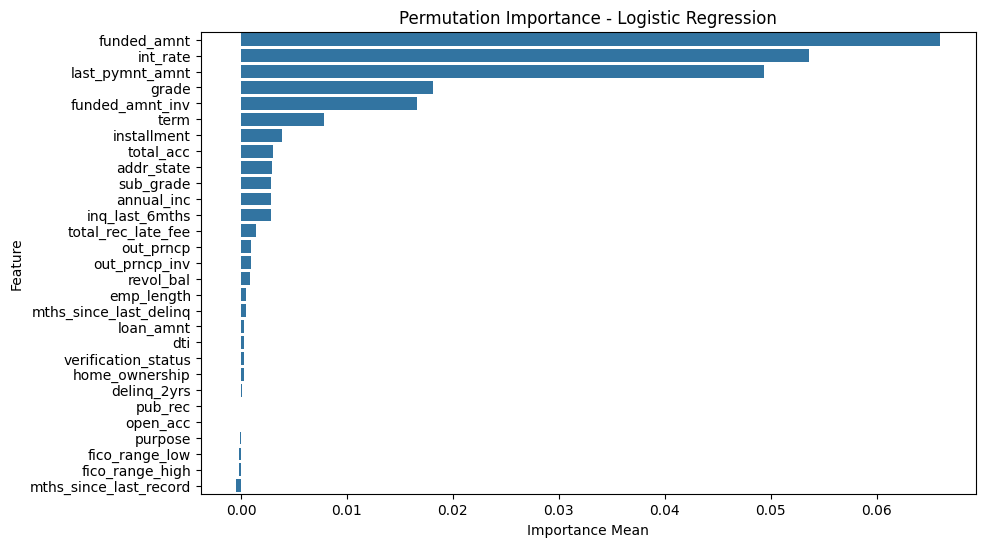

Pipeline Name: Random Forest
                   Feature  Importance Mean  Importance Std
0          last_pymnt_amnt         0.028962        0.001277
1       total_rec_late_fee         0.004416        0.000650
2                     term         0.004147        0.001301
3                 int_rate         0.002250        0.001038
4           fico_range_low         0.001360        0.001506
5      verification_status         0.000772        0.000774
6            out_prncp_inv         0.000604        0.000302
7                sub_grade         0.000487        0.000841
8              delinq_2yrs         0.000319        0.000447
9                revol_bal         0.000285        0.000879
10         funded_amnt_inv         0.000235        0.001137
11               out_prncp         0.000235        0.000293
12             funded_amnt         0.000118        0.001126
13                 pub_rec         0.000050        0.000319
14               loan_amnt         0.000000        0.001024
15         

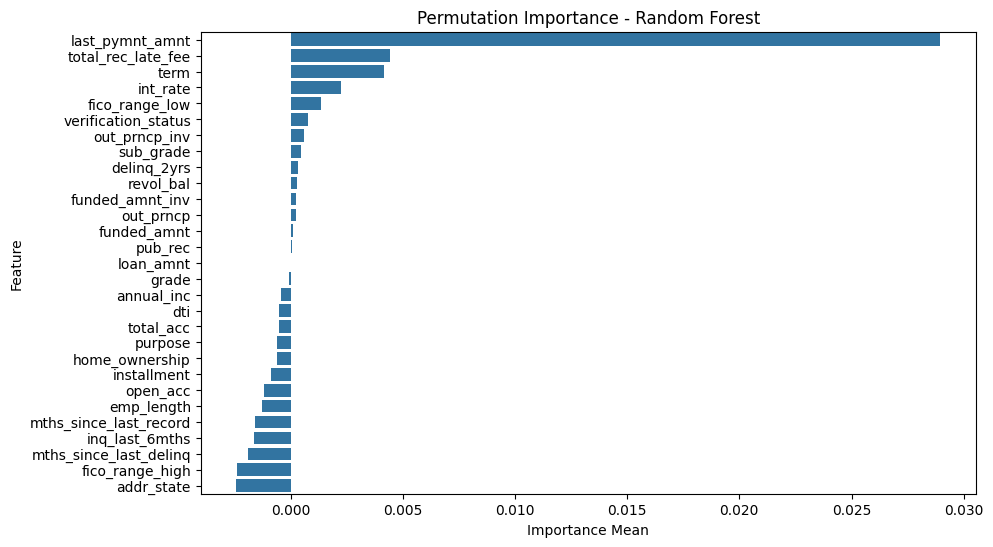

Pipeline Name: Gradient Boosting
                   Feature  Importance Mean  Importance Std
0          last_pymnt_amnt         0.070282        0.002904
1                     term         0.014372        0.002149
2       total_rec_late_fee         0.014171        0.001524
3          funded_amnt_inv         0.012475        0.001928
4              installment         0.011501        0.001654
5                 int_rate         0.011383        0.002056
6              funded_amnt         0.004987        0.002033
7                out_prncp         0.004080        0.000185
8           inq_last_6mths         0.003744        0.000873
9               annual_inc         0.003039        0.001280
10              addr_state         0.001914        0.001419
11               revol_bal         0.001478        0.000623
12               total_acc         0.001293        0.001005
13                 purpose         0.001226        0.000582
14          fico_range_low         0.001091        0.000778
15     

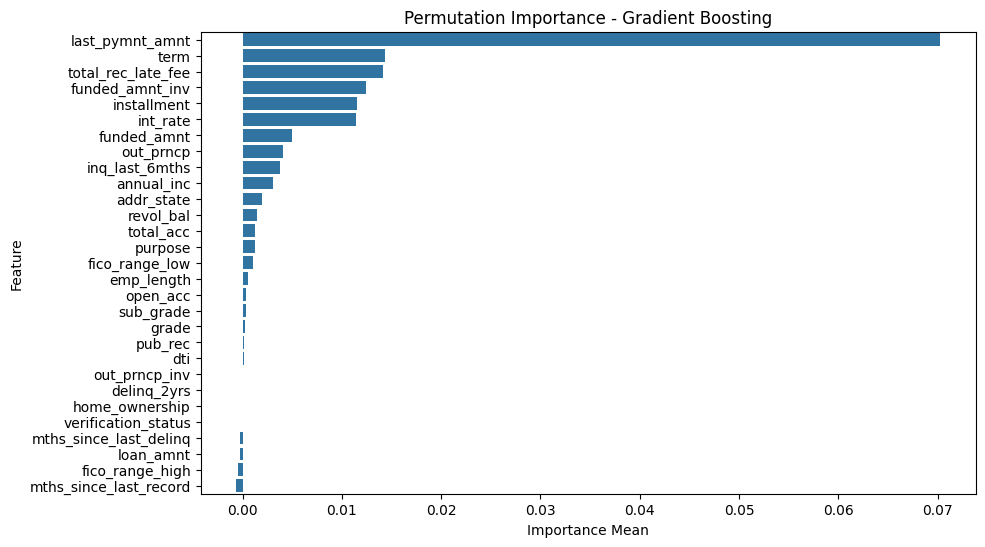

Pipeline Name: MLP
                   Feature  Importance Mean  Importance Std
0          last_pymnt_amnt     4.640698e-02        0.002445
1                 int_rate     4.096709e-02        0.001977
2              installment     2.068502e-02        0.002978
3              funded_amnt     1.769644e-02        0.003324
4                     term     1.428811e-02        0.001625
5                    grade     1.187038e-02        0.002744
6          funded_amnt_inv     9.855608e-03        0.002975
7               annual_inc     6.766286e-03        0.001827
8               addr_state     5.036938e-03        0.001550
9       total_rec_late_fee     4.096709e-03        0.001693
10                 pub_rec     3.760913e-03        0.000991
11          inq_last_6mths     3.660175e-03        0.001854
12          home_ownership     3.223640e-03        0.001757
13               total_acc     3.055742e-03        0.001414
14               revol_bal     2.871054e-03        0.001720
15                 pu

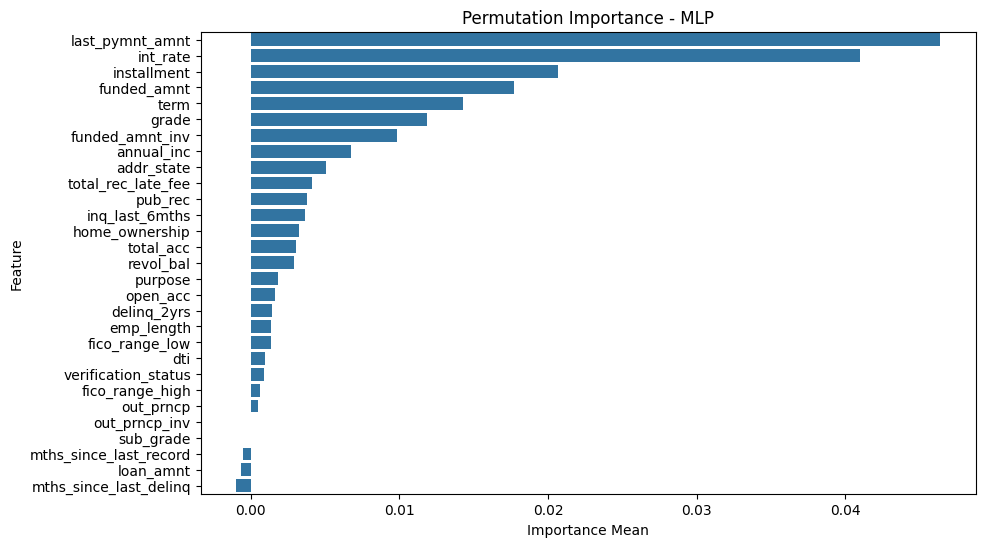

Pipeline Name: Stacking Classifier
                   Feature  Importance Mean  Importance Std
0          last_pymnt_amnt         0.060460        0.002332
1              installment         0.023942        0.002085
2       total_rec_late_fee         0.017999        0.001789
3               annual_inc         0.011249        0.001811
4                 int_rate         0.010275        0.001722
5                     term         0.010040        0.001168
6              funded_amnt         0.007824        0.001502
7          funded_amnt_inv         0.007623        0.001352
8                out_prncp         0.005154        0.000238
9           inq_last_6mths         0.002199        0.001202
10                   grade         0.002048        0.000649
11               loan_amnt         0.001729        0.001114
12              addr_state         0.001091        0.000965
13               total_acc         0.000974        0.001015
14               sub_grade         0.000873        0.000780
15   

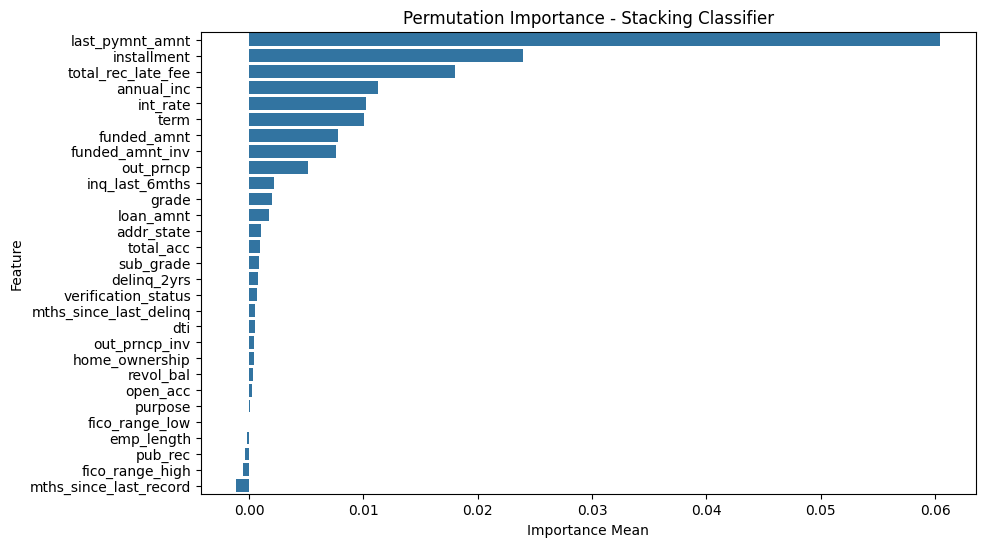

In [ ]:
# Compare the feature importance importance from one model to another
import seaborn as sns
from sklearn.inspection import permutation_importance

# Create a figure for the subplots
plt.figure(figsize=(20, 8))

# Loop through each pipeline
for pipeline, name in zip(pipelines, pipeline_names):
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict probabilities for the test set
    y_test_prob = pipeline.predict_proba(X_test)[:, 1]

    # Calculate permutation importance
    result = permutation_importance(pipeline, X_test, y_test,
                                    n_repeats=10, random_state=42,
                                    n_jobs=-1)

    # Feature names
    feature_names = numeric_features + categorical_features

    # Create DataFrame for feature importances
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance Mean': result.importances_mean,
        'Importance Std': result.importances_std
    }).sort_values(by='Importance Mean', ascending=False).reset_index(drop=True)

    # Display feature importances with pipeline name
    print(f"Pipeline Name: {name}")
    print(feature_importances_df)
    print()  # Add an empty line for better readability

    # Plot permutation importance for each pipeline
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importances_df, x='Importance Mean', y='Feature')
    plt.title(f'Permutation Importance - {name}')
    plt.show()


Feature importance of Best model by using dalex library

In [ ]:
!pip install dalex

In [ ]:
import dalex as dx # for explanations
pipeline_explainer = dx.Explainer(stk_pipeline, X_test, y_test)
pipeline_explainer

Preparation of a new explainer is initiated

  -> data              : 5956 rows 32 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 5956 values
  -> data              : A column identical to the target variable `y` has been found in the `data`.
  -> data              : It is highly recommended to pass `data` without the target variable column.
  -> model_class       : sklearn.ensemble._stacking.StackingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7dfee3e6a170> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.026, mean = 0.144, max = 0.948
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.925,

In [ ]:
model_performance  = pipeline_explainer.model_performance("classification")
model_performance.result

recall  precision   f1  accuracy       auc
StackingClassifier  0.3916   0.691383  0.5   0.88415  0.894005

In [ ]:
# Calculate feature importance
fi = pipeline_explainer.model_parts(processes=4)

# Plot feature importance
fi.plot()

## Partial Dependance Plot

### Numeric_features

In [ ]:
numeric_features

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_rec_late_fee',
 'last_pymnt_amnt']

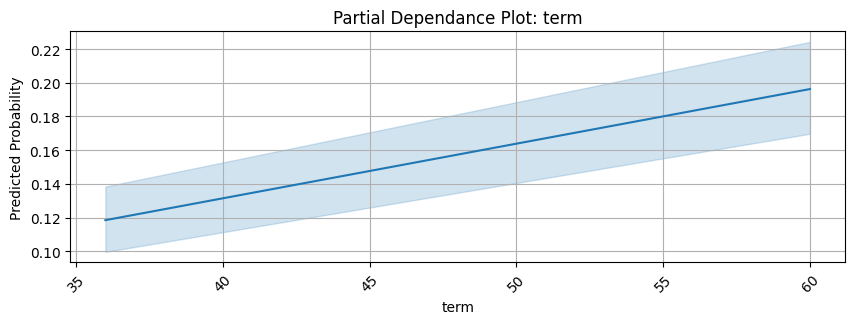

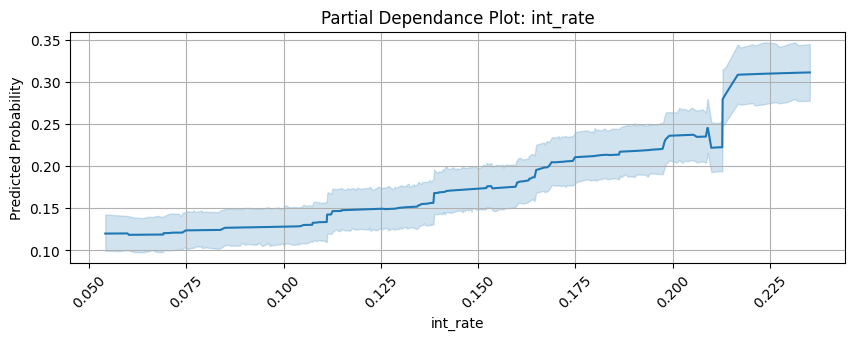

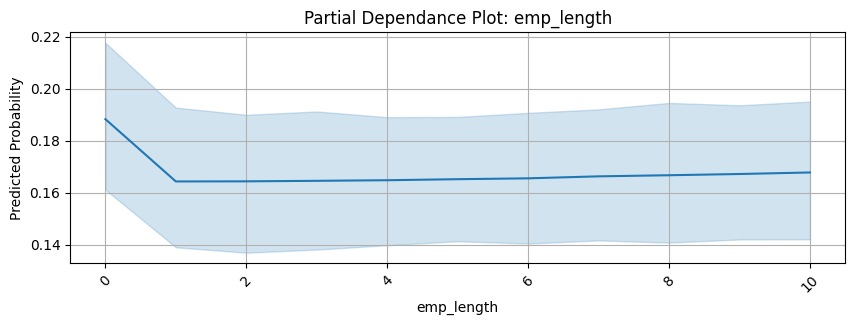

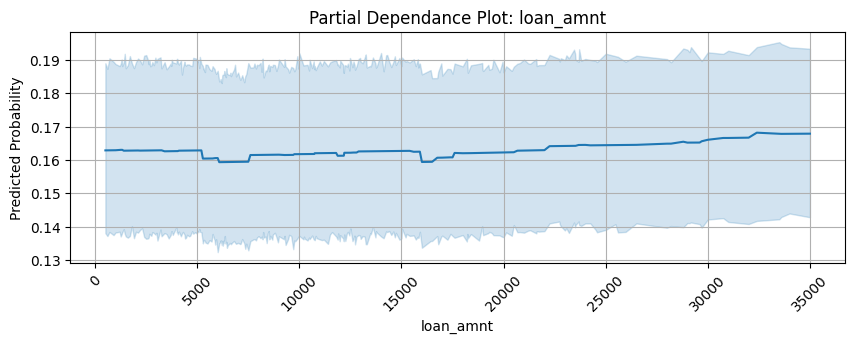

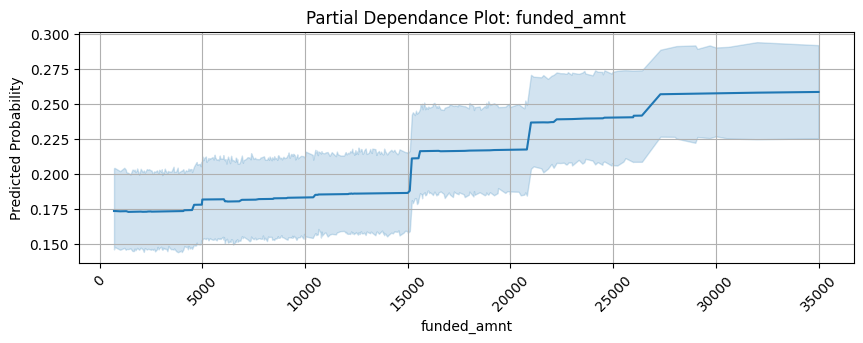

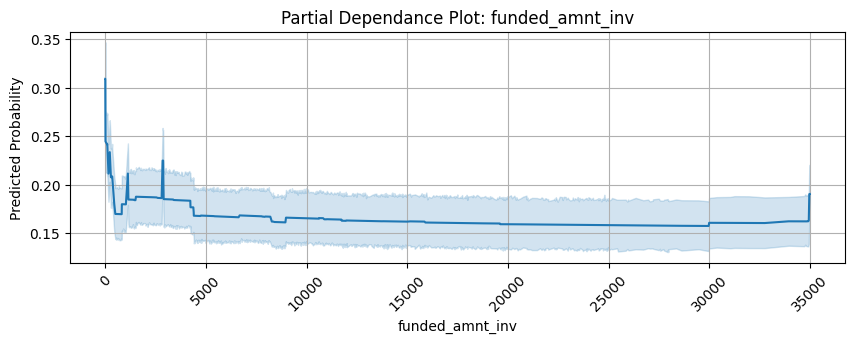

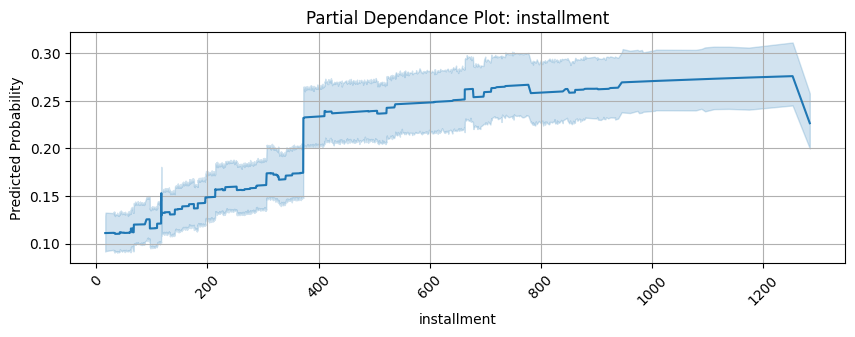

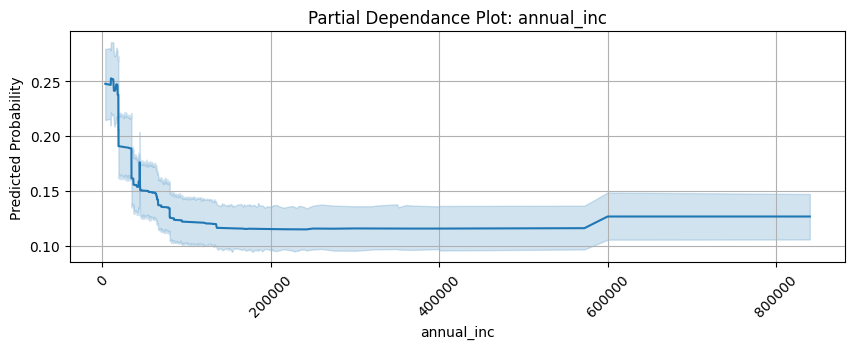

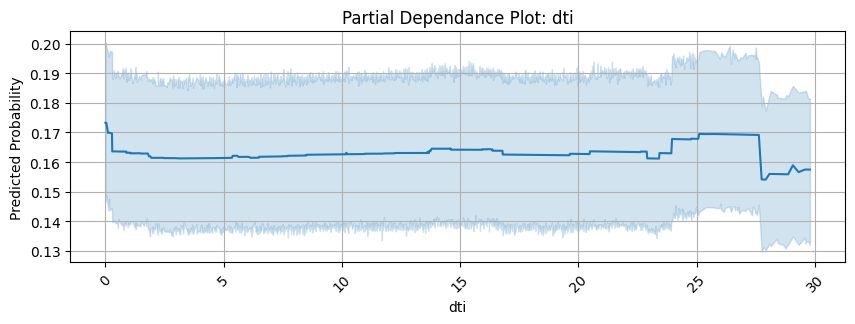

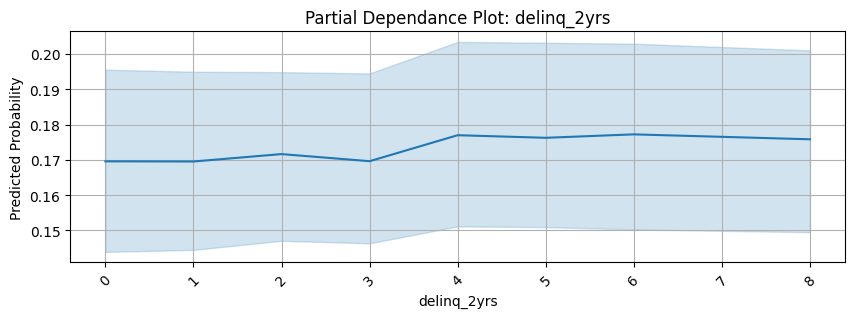

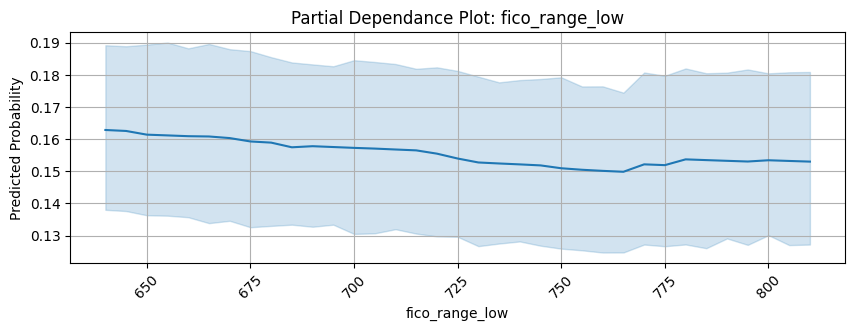

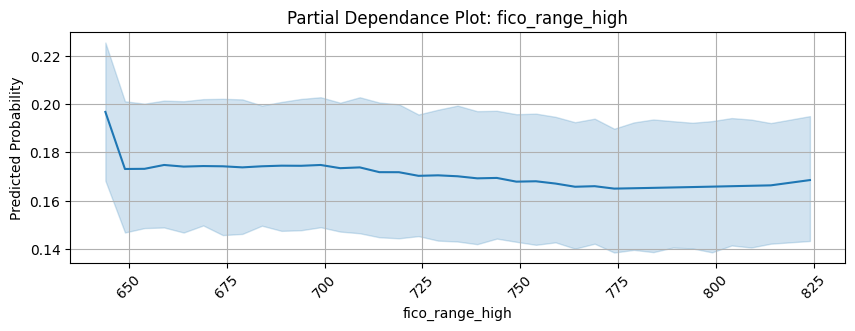

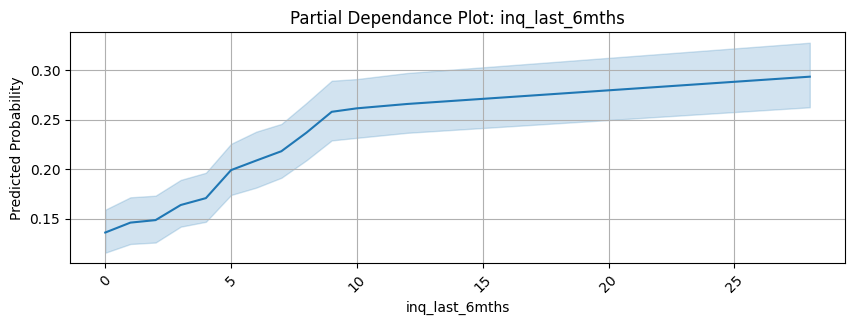

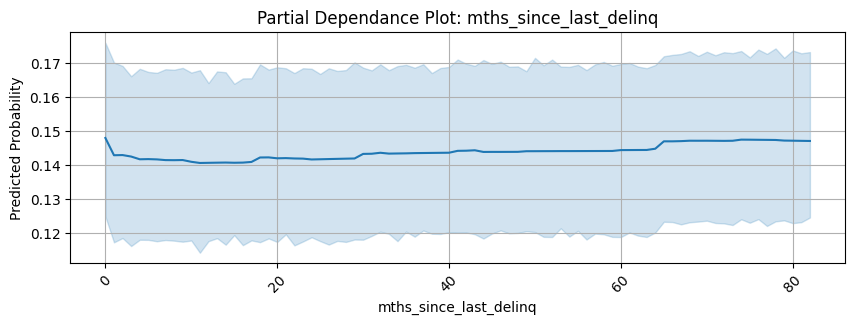

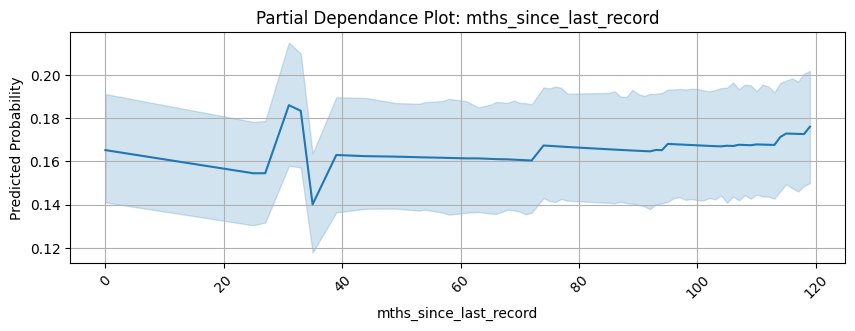

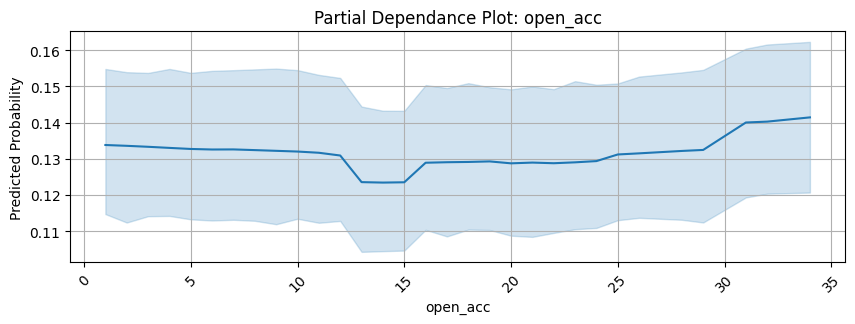

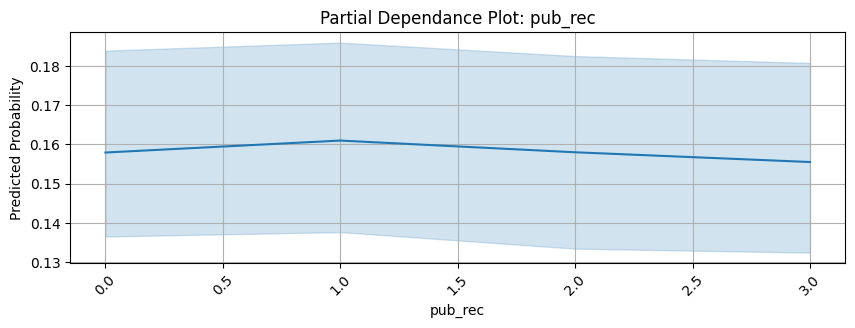

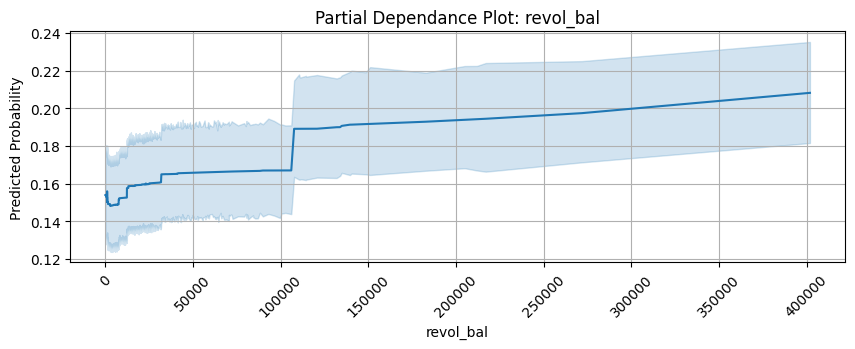

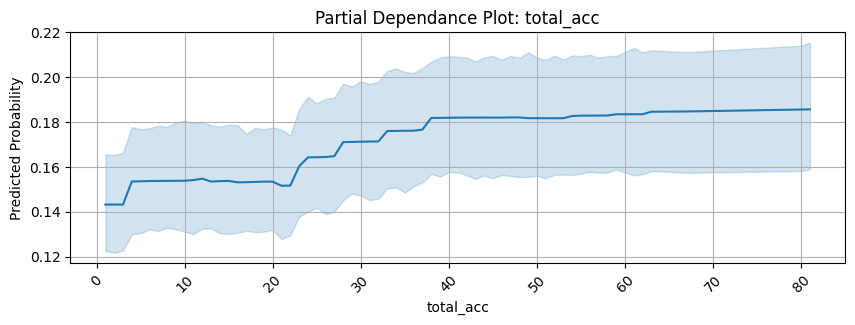

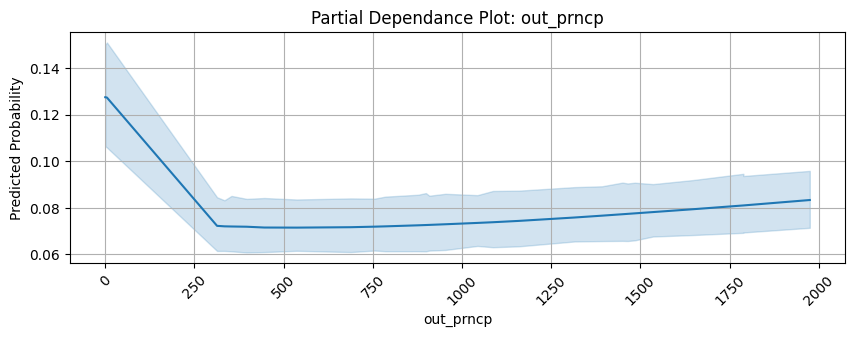

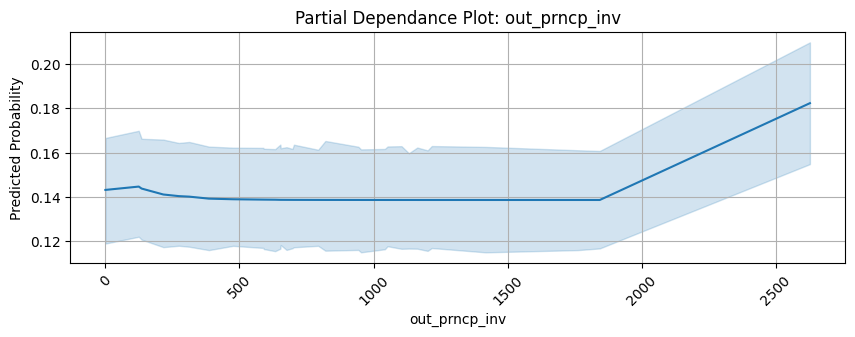

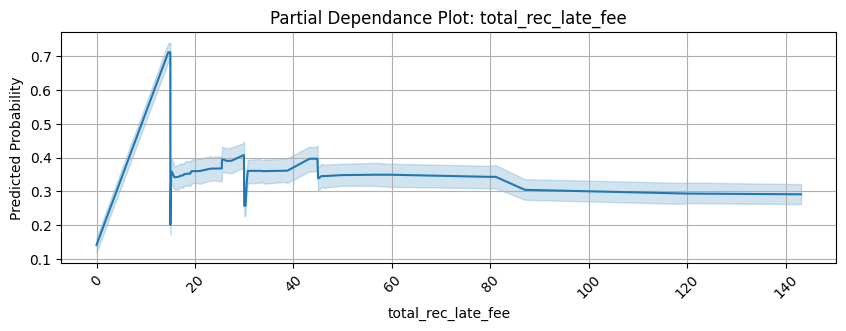

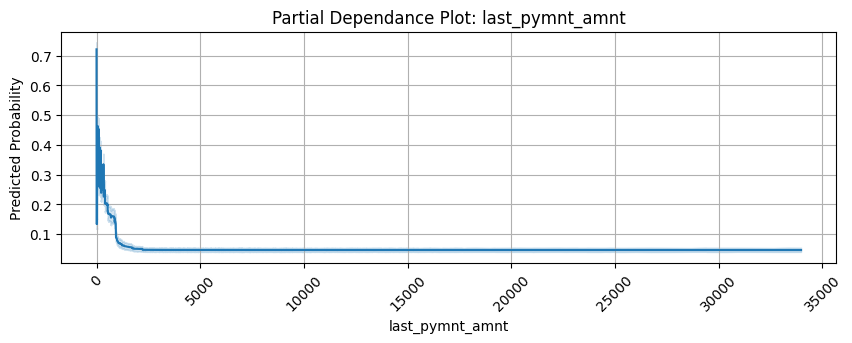

In [ ]:

def pdp_plot_numeric(var, sample_n):
  # var = 'credit_amount'
  pdp_values = pd.DataFrame(X_train[var].sort_values().sample(frac=0.1).unique(),columns=[var])
  pdp_sample = X_train.sample(sample_n).drop(var, axis=1)

  pdp_cross = pdp_sample.merge(pdp_values, how='cross')
  pdp_cross['pred'] = stk_pipeline.predict_proba(pdp_cross)[:,1]
  plt.figure(figsize=(10, 3))
  sns.lineplot(x=f"{var}", y='pred', data=pdp_cross)
  plt.title(f"Partial Dependance Plot: {var}")
  plt.ylabel('Predicted Probability')
  plt.xticks(rotation=45)
  #plt.ylim(0, 1)
  plt.grid(True)
  plt.show()

# numeric_features = ['credit_amount', 'duration', 'age']
for var in numeric_features:
  pdp_plot_numeric(var, sample_n=300)

### Categorical features

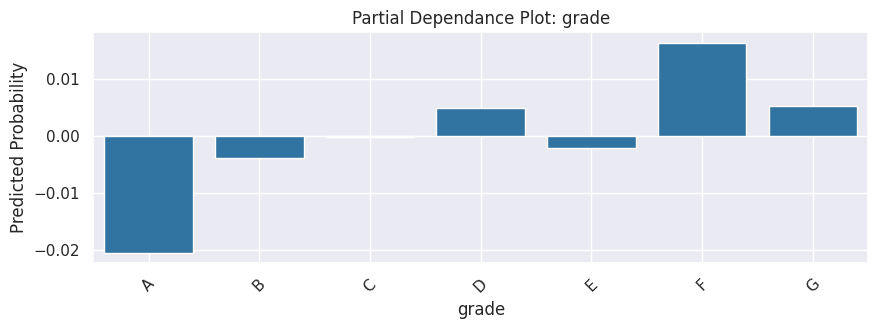

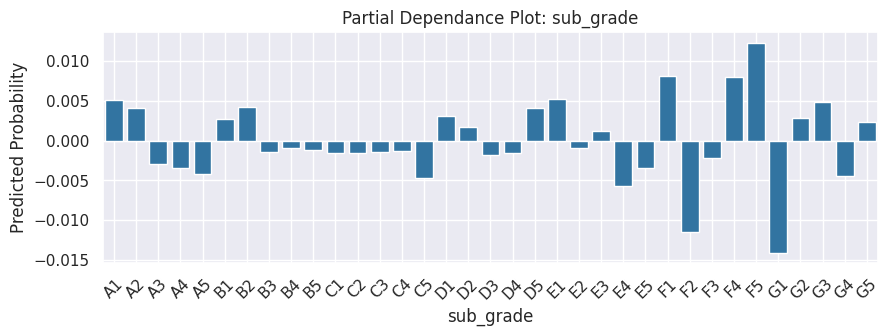

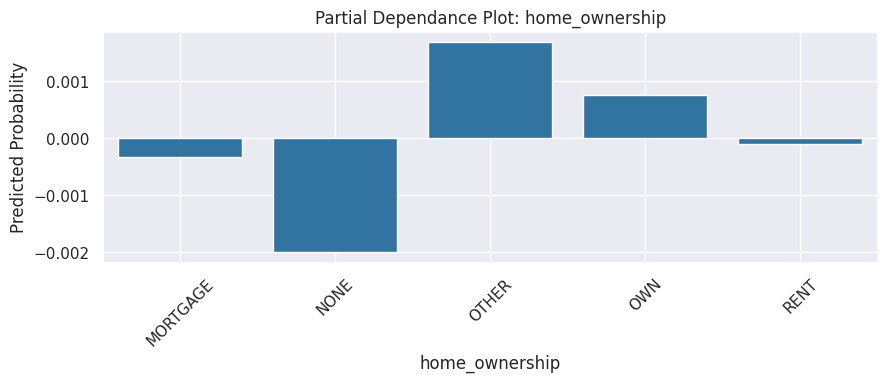

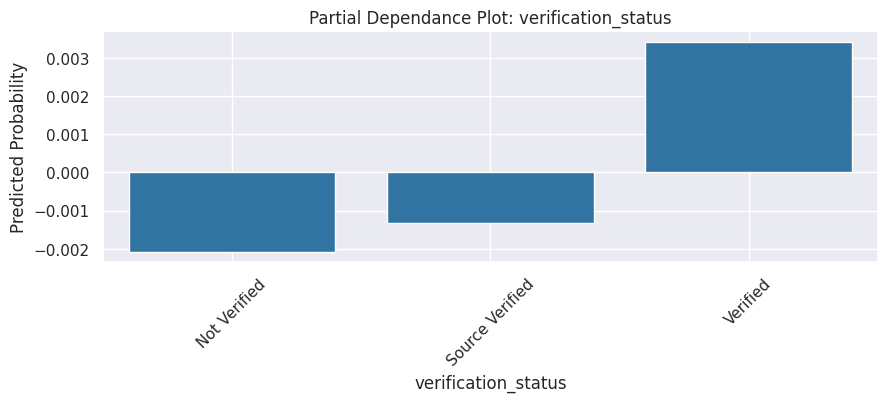

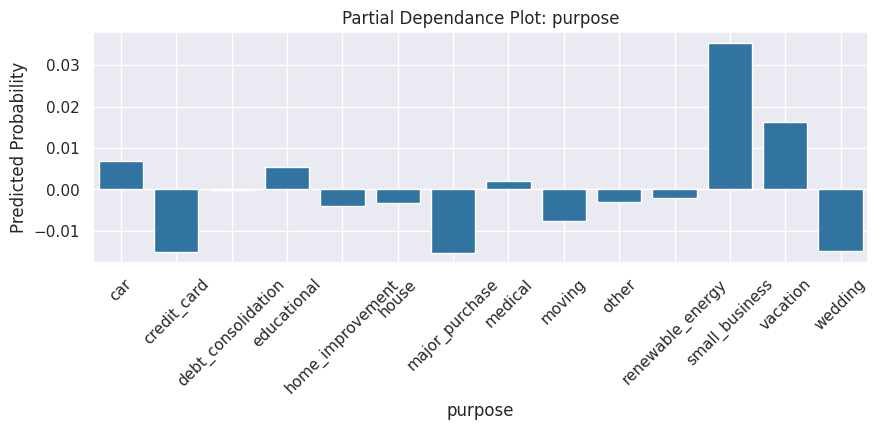

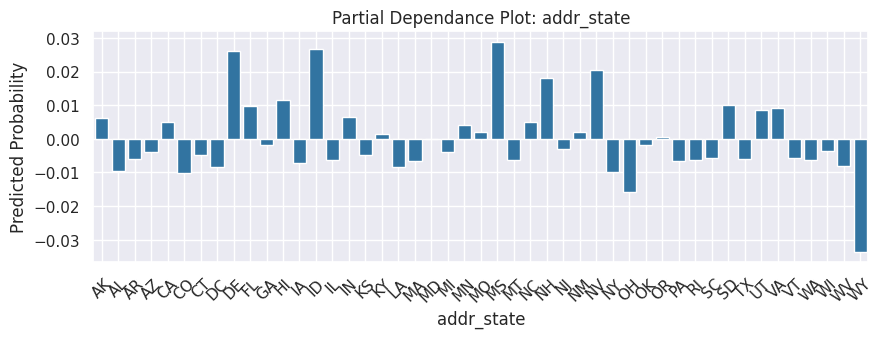

In [ ]:
def pdp_plot_categorical(var, sample_n):
  sns.set_style("darkgrid")  # Try "darkgrid", "ticks", etc.
  sns.set_context("notebook")  # Try "paper", "notebook", "poster" for different sizes

  pdp_values = pd.DataFrame(X_test[var].sort_values().unique(),columns=[var])
  pdp_sample = X_test.sample(sample_n).drop(var, axis=1)

  pdp_cross = pdp_sample.merge(pdp_values, how='cross')
  pdp_cross['pred'] = stk_pipeline.predict_proba(pdp_cross)[:,1]
  mean_pred = pdp_cross['pred'].mean()
  pdp_cross['pred'] = pdp_cross['pred'].apply(lambda x: x - mean_pred)
  plt.figure(figsize=(10, 3))
 #sns.lineplot(x=f"{var}", y='pred', data=pdp_cross)
  sns.barplot(x=f"{var}", y='pred',
              ci=None,
              data=pdp_cross,
              estimator="mean")
  plt.title(f"Partial Dependance Plot: {var}")
  plt.ylabel('Predicted Probability')
  plt.xticks(rotation=45)
  #plt.ylim(0, 1)
  plt.grid(True)
  plt.show()


for var in categorical_features:
  pdp_plot_categorical(var, sample_n=100)

### Another method to show PDP

In [125]:
# Let's say you want to create PDPs for a feature named 'feature_name'
pdp_numeric_profile = pipeline_explainer.model_profile(variables=numeric_features)

# Now, plot the PDP for 'feature_name'
pdp_numeric_profile.plot()

Calculating ceteris paribus: 100%|██████████| 23/23 [00:06<00:00,  3.57it/s]


In [126]:
pdp_categorical_profile = pipeline_explainer.model_profile(
    variable_type = 'categorical',
    variables=categorical_features)

# Now, plot the PDP for 'feature_name'
pdp_categorical_profile.plot()

Calculating ceteris paribus: 100%|██████████| 6/6 [00:00<00:00, 15.56it/s]


# Local predictions

In [85]:
X_test['pred']= stk_pipeline.predict(X_test)
X_test['pred_proba']= stk_pipeline.predict_proba(X_test)[:,1]
X_test[target] = y_test
X_test.head()

term  int_rate  emp_length  loan_amnt  funded_amnt  funded_amnt_inv  \
13494    36    0.0542           1     4375.0       4375.0      4225.000000   
21759    36    0.1025           3    10000.0      10000.0      9475.000000   
11247    60    0.1417           8    24000.0      24000.0     22921.129991   
25028    36    0.1411           4     5550.0       5550.0      5550.000000   
20440    60    0.1398           3    10000.0      10000.0      9875.000000   

       installment  annual_inc    dti  delinq_2yrs  ...  last_pymnt_amnt  \
13494       131.95     17760.0  20.20          0.0  ...            36.57   
21759       323.85     55000.0  18.59          0.0  ...          1317.62   
11247       560.56     53000.0  22.42          0.0  ...         23722.52   
25028       189.98     50000.0  21.58          0.0  ...           202.16   
20440       232.58     45000.0   5.97          0.0  ...           232.58   

       grade  sub_grade  home_ownership  verification_status  \
13494      A         A1             OWN      Source Verified   
21759      B         B2            RENT         Not Verified   
11247      C         C5        MORTGAGE             Verified   
25028      D         D1        MORTGAGE         Not Verified   
20440      C         C3            RENT         Not Verified   

                  purpose  addr_state  pred  pred_proba  loan_status  
13494  debt_consolidation          AZ     0    0.066362            0  
21759    home_improvement          NY     0    0.032126            0  
11247  debt_consolidation          WV     0    0.039415            0  
25028         credit_card          CA     0    0.184558            0  
20440  debt_consolidation          CA     0    0.320855            1  

[5 rows x 32 columns]

## TP-top 10 true postive, loan default = 1, predictive loan = 1

In [94]:
top_10_tp = (X_test
             .query('loan_status == pred and loan_status == 1')
             .sort_values(by='pred_proba', ascending=False)
             .head(10)
             .reset_index(drop=True)
)
top_10_tp

term  int_rate  emp_length  loan_amnt  funded_amnt  funded_amnt_inv  \
0    60    0.2174           1    18000.0      18000.0     12450.000005   
1    60    0.1903          10    30000.0      30000.0      7100.000000   
2    60    0.1528          10    12000.0      12000.0     12000.000000   
3    36    0.1438           7     7200.0       7200.0      1849.993412   
4    60    0.1979           0     8000.0       8000.0      8000.000000   
5    60    0.1864           5    35000.0      35000.0     35000.000000   
6    60    0.1398          10     3000.0       3000.0      3000.000000   
7    60    0.1751           3     8000.0       8000.0      7975.000000   
8    60    0.2025           2    21000.0      21000.0     20975.000000   
9    60    0.1862          10    30000.0      30000.0     29975.000000   

   installment  annual_inc    dti  delinq_2yrs  ...  last_pymnt_amnt  grade  \
0       494.49     36000.0  11.27          0.0  ...             0.03      F   
1       778.72     51600.0  19.09          0.0  ...             0.00      E   
2       287.25     60000.0  24.02          3.0  ...           103.98      D   
3       247.41     53000.0  15.65          0.0  ...           757.23      E   
4       211.02     34992.0  12.21          0.0  ...           211.02      F   
5       901.01    115000.0  11.45          0.0  ...           368.00      E   
6        69.78     74400.0   1.18          0.0  ...            84.78      C   
7       201.03     40000.0  14.07          0.0  ...           201.03      E   
8       559.30     73500.0  14.53          0.0  ...            34.39      F   
9       771.96     93468.0  18.87          1.0  ...            36.37      F   

   sub_grade  home_ownership  verification_status             purpose  \
0         F5            RENT             Verified      small_business   
1         E2        MORTGAGE             Verified  debt_consolidation   
2         D3        MORTGAGE         Not Verified      small_business   
3         E4        MORTGAGE         Not Verified      major_purchase   
4         F5        MORTGAGE             Verified  debt_consolidation   
5         E1        MORTGAGE      Source Verified  debt_consolidation   
6         C3             OWN      Source Verified    home_improvement   
7         E4            RENT      Source Verified  debt_consolidation   
8         F1            RENT             Verified      small_business   
9         F2        MORTGAGE             Verified  debt_consolidation   

   addr_state  pred  pred_proba  loan_status  
0          NY     1    0.955922            1  
1          TX     1    0.945724            1  
2          IL     1    0.944078            1  
3          IN     1    0.941907            1  
4          IL     1    0.941837            1  
5          CA     1    0.941642            1  
6          UT     1    0.941312            1  
7          NJ     1    0.940669            1  
8          CA     1    0.939471            1  
9          FL     1    0.937289            1  

[10 rows x 32 columns]

In [95]:
for index, row in top_10_tp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_tp.iloc[index],
      type='break_down',
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()


### Shap Explainations TP

In [ ]:
for index, row in top_10_tp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_tp.iloc[index],
      type='shap',
      B=5,
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

### Break Down Interactions TP

In [ ]:
for index, row in top_10_tp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_tp.iloc[index],
      type='break_down_interactions',
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()


## TP-top 10 false postive, loan default =0, predictive loan = 1

In [97]:
top_10_fp = (X_test
             .query('loan_status != pred and loan_status == 0')
             .sort_values(by='pred_proba', ascending=False)
             .head(10)
             .reset_index(drop=True)
)
top_10_fp

term  int_rate  emp_length  loan_amnt  funded_amnt  funded_amnt_inv  \
0    60    0.2174           0    20000.0      20000.0     19950.000000   
1    60    0.2164           7    20000.0      20000.0     19975.000000   
2    60    0.2294           3     6400.0       6400.0      6400.000000   
3    60    0.2159           2    20000.0      20000.0     19975.000000   
4    60    0.1689           8    17600.0      17600.0     17575.000000   
5    60    0.2062          10    26000.0      26000.0     23525.556151   
6    36    0.1754           1     1200.0       1200.0       700.000000   
7    60    0.2127           8    24000.0      24000.0     23845.924172   
8    60    0.2085           5    20000.0      20000.0     19912.901304   
9    60    0.2352          10    32000.0      32000.0     31890.973337   

   installment  annual_inc    dti  delinq_2yrs  ...  last_pymnt_amnt  grade  \
0       549.43     45444.0  18.85          0.0  ...           548.98      F   
1       548.30     75000.0   8.00          0.0  ...           568.09      G   
2       180.20     66000.0   2.80          0.0  ...           180.02      F   
3       547.73     80000.0   6.79          0.0  ...           547.32      G   
4       436.37     72000.0  11.85          0.0  ...            28.49      D   
5       697.85     64800.0  22.91          1.0  ...           637.58      F   
6        43.11      9600.0   8.38          1.0  ...            43.81      G   
7       652.94     80000.0  21.51          0.0  ...           654.58      G   
8       539.39     60000.0   6.44          1.0  ...            94.34      G   
9       911.69     80000.0  17.65          0.0  ...           910.68      G   

   sub_grade  home_ownership  verification_status             purpose  \
0         F5             OWN             Verified  debt_consolidation   
1         G5        MORTGAGE             Verified  debt_consolidation   
2         F5            RENT      Source Verified      small_business   
3         G5            RENT         Not Verified  debt_consolidation   
4         D4            RENT             Verified      small_business   
5         F2        MORTGAGE             Verified  debt_consolidation   
6         G4            RENT         Not Verified         educational   
7         G4             OWN             Verified  debt_consolidation   
8         G3        MORTGAGE      Source Verified      major_purchase   
9         G3        MORTGAGE             Verified  debt_consolidation   

   addr_state  pred  pred_proba  loan_status  
0          NY     1    0.939222            0  
1          TX     1    0.932613            0  
2          OR     1    0.927542            0  
3          CA     1    0.918232            0  
4          VA     1    0.916380            0  
5          UT     1    0.913842            0  
6          GA     1    0.900114            0  
7          NY     1    0.896444            0  
8          TX     1    0.885806            0  
9          GA     1    0.884868            0  

[10 rows x 32 columns]

In [96]:
for index, row in top_10_fp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_fp.iloc[index],
      type='break_down',
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()


### ### Shap Explainations FP

In [98]:
for index, row in top_10_fp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_fp.iloc[index],
      type='shap',
      B=5,
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

### Break Down Interactions FP

In [99]:
for index, row in top_10_fp.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_fp.iloc[index],
      type='break_down_interactions',
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()


## TP-top 10 false negative, loan default = 1, predictive loan = 0
---

In [ ]:
top_10_fn = (X_test
             .query('loan_status != pred and loan_status == 1')
             .sort_values(by='pred_proba', ascending=True)
             .head(10)
             .reset_index(drop=True)
)
top_10_fn

term  int_rate  emp_length  loan_amnt  funded_amnt  funded_amnt_inv  \
0    36    0.0579           0     7000.0       7000.0      7000.000000   
1    36    0.0938           7    18000.0      13300.0      8999.994155   
2    36    0.1149           1     5000.0       5000.0      5000.000000   
3    60    0.0962           1    20000.0      20000.0     17991.544969   
4    60    0.1640           1    35000.0      35000.0     20775.004916   
5    36    0.0542           1     6000.0       6000.0      5950.000000   
6    36    0.0617          10    23000.0      23000.0     23000.000000   
7    36    0.0699           2     7100.0       7100.0      7100.000000   
8    60    0.1558           2    16000.0      16000.0     15900.000000   
9    60    0.1349           2    33425.0      20675.0     19010.821218   

   installment  annual_inc    dti  delinq_2yrs  ...  last_pymnt_amnt  grade  \
0       212.29     46932.0  26.00          0.0  ...          2300.00      A   
1       425.30     90000.0   8.93          0.0  ...          2000.00      A   
2       164.86     37000.0  19.20          0.0  ...          1763.84      B   
3       421.22     96000.0   0.99          1.0  ...          4841.69      B   
4       858.59    115000.0   6.47          0.0  ...         11800.00      E   
5       180.96     52800.0   5.73          0.0  ...           180.96      A   
6       701.48     98000.0  20.85          0.0  ...           701.48      A   
7       219.20     50400.0   0.14          0.0  ...           274.36      A   
8       385.53     78000.0   8.57          0.0  ...         10021.06      D   
9       475.63     75000.0  25.71          0.0  ...          1370.08      C   

   sub_grade  home_ownership  verification_status             purpose  \
0         A2             OWN             Verified      major_purchase   
1         A5        MORTGAGE         Not Verified      small_business   
2         B4            RENT             Verified         credit_card   
3         B3             OWN      Source Verified  debt_consolidation   
4         E1        MORTGAGE             Verified         credit_card   
5         A1        MORTGAGE      Source Verified            vacation   
6         A3        MORTGAGE             Verified  debt_consolidation   
7         A3            RENT      Source Verified      major_purchase   
8         D3        MORTGAGE             Verified  debt_consolidation   
9         C1        MORTGAGE      Source Verified  debt_consolidation   

   addr_state  pred  pred_proba  loan_status  
0          CO     0    0.030548            1  
1          OH     0    0.034090            1  
2          VA     0    0.034656            1  
3          NY     0    0.036709            1  
4          CA     0    0.038402            1  
5          VA     0    0.038660            1  
6          NJ     0    0.039532            1  
7          CA     0    0.040167            1  
8          MN     0    0.041217            1  
9          NY     0    0.041676            1  

[10 rows x 32 columns]

### Shap Explainations FN


In [ ]:
for index, row in top_10_fn.iterrows():
  local_breakdown_exp = pipeline_explainer.predict_parts(
      top_10_fn.iloc[index],
      type='shap',
      B=5,
      label=f"record:{index}, prob:{row['pred_proba']:.3f}")

  local_breakdown_exp.plot()

# Make a prediciton into csv file.
- Since the final model I choose is stacking model, I use this model to make a prediction

In [101]:
df_p = pd.read_csv('/content/loan_holdout.csv')

In [102]:
# Fill missing values in 'term' column with a default value
df_p['term'].fillna('0 months', inplace=True)

In [103]:
# Extract numeric part from 'term' column and convert to integer
df_p['term'] = df_p['term'].str.extract('(\d+)').astype(float).fillna(0).astype(int)
df_p['term'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 12761 entries, 0 to 12760
Series name: term
Non-Null Count  Dtype
--------------  -----
12761 non-null  int64
dtypes: int64(1)
memory usage: 99.8 KB


In [104]:
# Convert Interest Rate from String to Decimal:
df_p['int_rate'] = df_p['int_rate'].str.rstrip('%').astype(float) / 100
df_p['int_rate'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 12761 entries, 0 to 12760
Series name: int_rate
Non-Null Count  Dtype  
--------------  -----  
12761 non-null  float64
dtypes: float64(1)
memory usage: 99.8 KB


In [105]:
df_p['emp_length'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 12761 entries, 0 to 12760
Series name: emp_length
Non-Null Count  Dtype 
--------------  ----- 
12408 non-null  object
dtypes: object(1)
memory usage: 99.8+ KB


In [106]:
# Fill missing values in 'emp_length' column with a default value
df_p['emp_length'].fillna('0 years', inplace=True)

In [107]:
# Extract numeric part from 'emp_length' column and convert to integer
df_p['emp_length'] = df_p['emp_length'].str.extract('(\d+)').astype(int)
df_p['emp_length'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 12761 entries, 0 to 12760
Series name: emp_length
Non-Null Count  Dtype
--------------  -----
12761 non-null  int64
dtypes: int64(1)
memory usage: 99.8 KB


In [108]:
# make a probability prediction
y_prob = stk_pipeline.predict_proba(df_p)[:, 1]

In [109]:
y_prob

array([0.08027332, 0.06506352, 0.06407929, ..., 0.05171497, 0.45357599,
       0.16410528])

In [110]:
df_p['y_prob'] = y_prob

In [112]:
result_df = df_p[['id','y_prob']]
result_df.head()

id    y_prob
0  1077175  0.080273
1  1075358  0.065064
2  1075269  0.064079
3  1071570  0.452205
4  1064687  0.129355

In [113]:
# Output the handout result
result_df.to_csv('Final_holdout.csv', index = False)